# **Regression Analysis**

## **Housing Price Prediction**

In [ ]:

!pip install scikit-learn matplotlib seaborn statsmodels

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing, make_regression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

print("All packages installed and imported successfully!")

All packages installed and imported successfully!


In [ ]:
class DataPreprocessor:
    def __init__(self, numerical_features, categorical_features):
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
        self.preprocessor = None

    def create_preprocessor(self):
        numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])

        # REMOVED the 'sparse' parameter - it's no longer needed
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Fixed: removed sparse=False
        ])

        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, self.numerical_features),
                ('cat', categorical_transformer, self.categorical_features)
            ])
        return self.preprocessor

In [ ]:
class RegressionModels:
    def __init__(self):
        self.models = {
            'linear_regression': LinearRegression(),
            'ridge': Ridge(random_state=42),
            'lasso': Lasso(random_state=42),
            'elastic_net': ElasticNet(random_state=42),
            'random_forest': RandomForestRegressor(random_state=42),
            'gradient_boosting': GradientBoostingRegressor(random_state=42),
            'svr': SVR()
        }

        self.param_grids = {
            'ridge': {'alpha': [0.1, 1.0, 10.0, 100.0]},
            'lasso': {'alpha': [0.1, 1.0, 10.0]},
            'elastic_net': {
                'alpha': [0.1, 1.0, 10.0],
                'l1_ratio': [0.2, 0.5, 0.8]
            },
            'random_forest': {
                'n_estimators': [100, 200],
                'max_depth': [10, 20, None],
                'min_samples_split': [2, 5]
            },
            'gradient_boosting': {
                'n_estimators': [100, 200],
                'learning_rate': [0.1, 0.05],
                'max_depth': [3, 5]
            },
            'svr': {
                'C': [0.1, 1, 10],
                'kernel': ['linear', 'rbf']
            }
        }

    def train_models(self, X_train, y_train, cv=5):
        results = {}

        print("Training Models...")
        print("-" * 50)

        for name, model in self.models.items():
            print(f"Training {name}...")

            if name in self.param_grids:
                # Perform grid search for hyperparameter tuning
                grid_search = GridSearchCV(
                    model, self.param_grids[name],
                    cv=cv, scoring='neg_mean_squared_error',
                    n_jobs=-1
                )
                grid_search.fit(X_train, y_train)
                best_model = grid_search.best_estimator_
                best_score = -grid_search.best_score_
                best_params = grid_search.best_params_
            else:
                # Use default parameters
                scores = cross_val_score(
                    model, X_train, y_train,
                    cv=cv, scoring='neg_mean_squared_error',
                    n_jobs=-1
                )
                best_model = model.fit(X_train, y_train)
                best_score = -scores.mean()
                best_params = "default"

            results[name] = {
                'model': best_model,
                'cv_score': best_score,
                'params': best_params,
                'cv_rmse': np.sqrt(best_score)
            }

            print(f"{name:20} | CV RMSE: {np.sqrt(best_score):.4f}")

        print("-" * 50)
        return results

In [ ]:
class RegressionEvaluator:
    def __init__(self):
        self.metrics = {}

    def calculate_metrics(self, y_true, y_pred, model_name):
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        # Additional metrics with error handling for zero values
        with np.errstate(divide='ignore', invalid='ignore'):
            mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true != 0, y_true, 1))) * 100

        self.metrics[model_name] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'MAPE': mape
        }

        return self.metrics[model_name]

    def plot_residuals(self, y_true, y_pred, model_name):
        residuals = y_true - y_pred

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'Residual Analysis - {model_name}', fontsize=16)

        # Residuals vs Predicted
        axes[0, 0].scatter(y_pred, residuals, alpha=0.6)
        axes[0, 0].axhline(y=0, color='red', linestyle='--')
        axes[0, 0].set_xlabel('Predicted Values')
        axes[0, 0].set_ylabel('Residuals')
        axes[0, 0].set_title('Residuals vs Predicted')

        # Q-Q plot
        stats.probplot(residuals, dist="norm", plot=axes[0, 1])
        axes[0, 1].set_title('Q-Q Plot')

        # Distribution of residuals
        axes[1, 0].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
        axes[1, 0].set_xlabel('Residuals')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_title('Distribution of Residuals')

        # Actual vs Predicted
        axes[1, 1].scatter(y_true, y_pred, alpha=0.6)
        max_val = max(y_true.max(), y_pred.max())
        min_val = min(y_true.min(), y_pred.min())
        axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'red', lw=2)
        axes[1, 1].set_xlabel('Actual')
        axes[1, 1].set_ylabel('Predicted')
        axes[1, 1].set_title('Actual vs Predicted')

        plt.tight_layout()
        plt.show()

    def compare_models(self):
        metrics_df = pd.DataFrame(self.metrics).T
        return metrics_df.sort_values('RMSE')

    def plot_model_comparison(self):
        metrics_df = self.compare_models()

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # RMSE Comparison
        axes[0, 0].barh(metrics_df.index, metrics_df['RMSE'])
        axes[0, 0].set_xlabel('RMSE')
        axes[0, 0].set_title('Model Comparison - RMSE (Lower is Better)')

        # R² Comparison
        axes[0, 1].barh(metrics_df.index, metrics_df['R2'])
        axes[0, 1].set_xlabel('R² Score')
        axes[0, 1].set_title('Model Comparison - R² (Higher is Better)')

        # MAE Comparison
        axes[1, 0].barh(metrics_df.index, metrics_df['MAE'])
        axes[1, 0].set_xlabel('MAE')
        axes[1, 0].set_title('Model Comparison - MAE (Lower is Better)')

        # MAPE Comparison
        axes[1, 1].barh(metrics_df.index, metrics_df['MAPE'])
        axes[1, 1].set_xlabel('MAPE (%)')
        axes[1, 1].set_title('Model Comparison - MAPE (Lower is Better)')

        plt.tight_layout()
        plt.show()

In [ ]:
class ModelInterpreter:
    def __init__(self, model, feature_names):
        self.model = model
        self.feature_names = feature_names

    def plot_feature_importance(self, X, y, method='permutation'):
        """Plot feature importance using different methods"""

        plt.figure(figsize=(10, 6))

        if method == 'permutation' and hasattr(self.model, 'predict'):
            result = permutation_importance(
                self.model, X, y, n_repeats=10, random_state=42, n_jobs=-1
            )
            importance = result.importances_mean
            title = 'Permutation Feature Importance'
        elif hasattr(self.model, 'feature_importances_'):
            importance = self.model.feature_importances_
            title = 'Feature Importance (Gini)'
        elif hasattr(self.model, 'coef_'):
            importance = np.abs(self.model.coef_)
            title = 'Feature Importance (Coefficient Magnitude)'
        else:
            raise ValueError("Model doesn't support feature importance calculation")

        # Create feature importance dataframe
        feature_imp = pd.DataFrame({
            'feature': self.feature_names,
            'importance': importance
        }).sort_values('importance', ascending=True)

        # Plot
        plt.barh(feature_imp['feature'], feature_imp['importance'])
        plt.xlabel('Feature Importance')
        plt.title(title)
        plt.tight_layout()
        plt.show()

        return feature_imp

In [ ]:
class HousingPricePrediction:
    def __init__(self):
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.preprocessor = None
        self.models = None
        self.evaluator = RegressionEvaluator()

    def load_and_explore_data(self):
        """Load and explore the California Housing dataset"""
        print("Loading California Housing Dataset...")
        housing = fetch_california_housing()
        self.data = pd.DataFrame(housing.data, columns=housing.feature_names)
        self.data['PRICE'] = housing.target * 100000  # Convert to actual price

        print("Dataset Shape:", self.data.shape)
        print("\nDataset Description:")
        print(self.data.describe())

        # Display first few rows
        print("\nFirst 5 rows:")
        print(self.data.head())

        return self.data

    def perform_eda(self):
        """Perform Exploratory Data Analysis"""
        print("Performing Exploratory Data Analysis...")

        # 1. Correlation matrix
        plt.figure(figsize=(12, 8))
        correlation_matrix = self.data.corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
        plt.title('Correlation Matrix')
        plt.tight_layout()
        plt.show()

        # 2. Distribution of target variable
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.hist(self.data['PRICE'], bins=30, alpha=0.7, edgecolor='black', color='skyblue')
        plt.xlabel('House Price ($)')
        plt.ylabel('Frequency')
        plt.title('Distribution of House Prices')

        plt.subplot(1, 2, 2)
        stats.probplot(self.data['PRICE'], dist="norm", plot=plt)
        plt.title('Q-Q Plot of House Prices')

        plt.tight_layout()
        plt.show()

        # 3. Feature distributions
        self.data.hist(bins=30, figsize=(15, 10), color='lightgreen', alpha=0.7)
        plt.suptitle('Feature Distributions', y=1.02)
        plt.tight_layout()
        plt.show()

        # 4. Relationship between features and target
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        axes = axes.ravel()

        features = self.data.columns[:-1]  # Exclude target

        for i, feature in enumerate(features):
            axes[i].scatter(self.data[feature], self.data['PRICE'], alpha=0.5)
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Price')
            axes[i].set_title(f'{feature} vs Price')

        plt.tight_layout()
        plt.show()

    def preprocess_data(self):
        """Preprocess the data for modeling"""
        print("Preprocessing data...")

        # Define features
        numerical_features = self.data.columns[:-1].tolist()  # All except target
        categorical_features = []  # No categorical features in this dataset

        # Split data
        X = self.data.drop('PRICE', axis=1)
        y = self.data['PRICE']

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, shuffle=True
        )

        print(f"Training set size: {self.X_train.shape[0]}")
        print(f"Test set size: {self.X_test.shape[0]}")

        # Create and fit preprocessor
        preprocessor_obj = DataPreprocessor(numerical_features, categorical_features)
        self.preprocessor = preprocessor_obj.create_preprocessor()

        # Transform features
        self.X_train_processed = self.preprocessor.fit_transform(self.X_train)
        self.X_test_processed = self.preprocessor.transform(self.X_test)

        # Get feature names after preprocessing
        self.feature_names = numerical_features

        print(f"Processed training set shape: {self.X_train_processed.shape}")
        print(f"Processed test set shape: {self.X_test_processed.shape}")

        # Convert to DataFrame for better handling (optional)
        self.X_train_processed = pd.DataFrame(self.X_train_processed, columns=self.feature_names)
        self.X_test_processed = pd.DataFrame(self.X_test_processed, columns=self.feature_names)

    def train_all_models(self):
        """Train multiple regression models"""
        print("Training regression models...")
        model_trainer = RegressionModels()
        self.models = model_trainer.train_models(
            self.X_train_processed, self.y_train, cv=5
        )

    def evaluate_all_models(self):
        """Evaluate all trained models"""
        print("Evaluating models on test set...")
        print("-" * 60)

        for model_name, model_info in self.models.items():
            # Make predictions
            y_pred = model_info['model'].predict(self.X_test_processed)

            # Calculate metrics
            metrics = self.evaluator.calculate_metrics(
                self.y_test, y_pred, model_name
            )

            print(f"\n{model_name.upper()} Performance:")
            print(f"  RMSE: ${metrics['RMSE']:,.2f}")
            print(f"  MAE: ${metrics['MAE']:,.2f}")
            print(f"  R² Score: {metrics['R2']:.4f}")
            print(f"  MAPE: {metrics['MAPE']:.2f}%")

        # Plot residuals for the best model
        best_model_name = self.evaluator.compare_models().index[0]
        best_model_info = self.models[best_model_name]
        y_pred_best = best_model_info['model'].predict(self.X_test_processed)

        print(f"\nGenerating residual plots for best model: {best_model_name}")
        self.evaluator.plot_residuals(self.y_test, y_pred_best, best_model_name)

    def interpret_best_model(self):
        """Interpret the best performing model"""
        best_model_name = self.evaluator.compare_models().index[0]
        best_model = self.models[best_model_name]['model']

        print(f"Interpreting best model: {best_model_name}")

        interpreter = ModelInterpreter(best_model, self.feature_names)
        feature_importance = interpreter.plot_feature_importance(
            self.X_test_processed, self.y_test
        )

        print("\nFeature Importance Ranking:")
        print(feature_importance.sort_values('importance', ascending=False))

        return best_model_name, feature_importance

    def run_complete_analysis(self):
        """Run the complete regression analysis pipeline"""
        print("=" * 70)
        print("COMPREHENSIVE REGRESSION ANALYSIS: HOUSING PRICE PREDICTION")
        print("=" * 70)

        # Step 1: Load and explore data
        print("\n1. LOADING AND EXPLORING DATA")
        self.load_and_explore_data()
        self.perform_eda()

        # Step 2: Preprocess data
        print("\n2. PREPROCESSING DATA")
        self.preprocess_data()

        # Step 3: Train models
        print("\n3. TRAINING MODELS")
        self.train_all_models()

        # Step 4: Evaluate models
        print("\n4. EVALUATING MODELS")
        self.evaluate_all_models()

        # Step 5: Model comparison
        print("\n5. MODEL COMPARISON")
        comparison_df = self.evaluator.compare_models()
        print("\nOverall Model Performance (Sorted by RMSE):")
        print(comparison_df)

        # Visual comparison
        self.evaluator.plot_model_comparison()

        # Step 6: Interpret best model
        print("\n6. INTERPRETING BEST MODEL")
        best_model_name, feature_importance = self.interpret_best_model()

        # Final summary
        print("\n" + "=" * 70)
        print("FINAL SUMMARY")
        print("=" * 70)
        best_metrics = self.evaluator.metrics[best_model_name]
        print(f"Best Model: {best_model_name}")
        print(f"Best RMSE: ${best_metrics['RMSE']:,.2f}")
        print(f"Best R² Score: {best_metrics['R2']:.4f}")
        print(f"Mean Absolute Error: ${best_metrics['MAE']:,.2f}")
        print(f"Mean Absolute Percentage Error: {best_metrics['MAPE']:.2f}%")

        # Make sample predictions
        print(f"\nSample Predictions (First 10 test samples):")
        sample_indices = range(min(10, len(self.X_test)))
        actual_prices = self.y_test.iloc[sample_indices].values
        predicted_prices = self.models[best_model_name]['model'].predict(
            self.X_test_processed.iloc[sample_indices]
        )

        sample_results = pd.DataFrame({
            'Actual Price': actual_prices,
            'Predicted Price': predicted_prices,
            'Absolute Error': np.abs(actual_prices - predicted_prices),
            'Percentage Error': (np.abs(actual_prices - predicted_prices) / actual_prices) * 100
        })

        print(sample_results.to_string(float_format=lambda x: '${:,.2f}'.format(x) if x > 1000 else '{:.2f}%'.format(x)))

 Starting Complete Regression Project...
COMPREHENSIVE REGRESSION ANALYSIS: HOUSING PRICE PREDICTION

1. LOADING AND EXPLORING DATA
Loading California Housing Dataset...
Dataset Shape: (20640, 9)

Dataset Description:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude          PRICE  
count

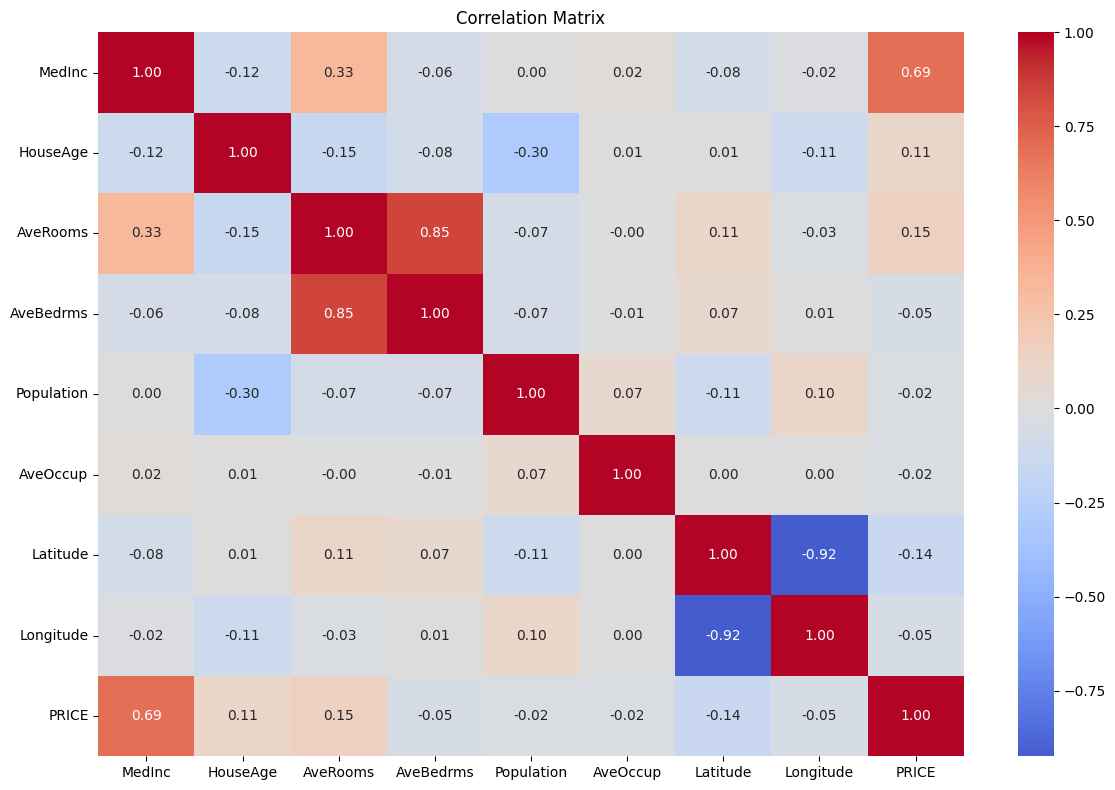

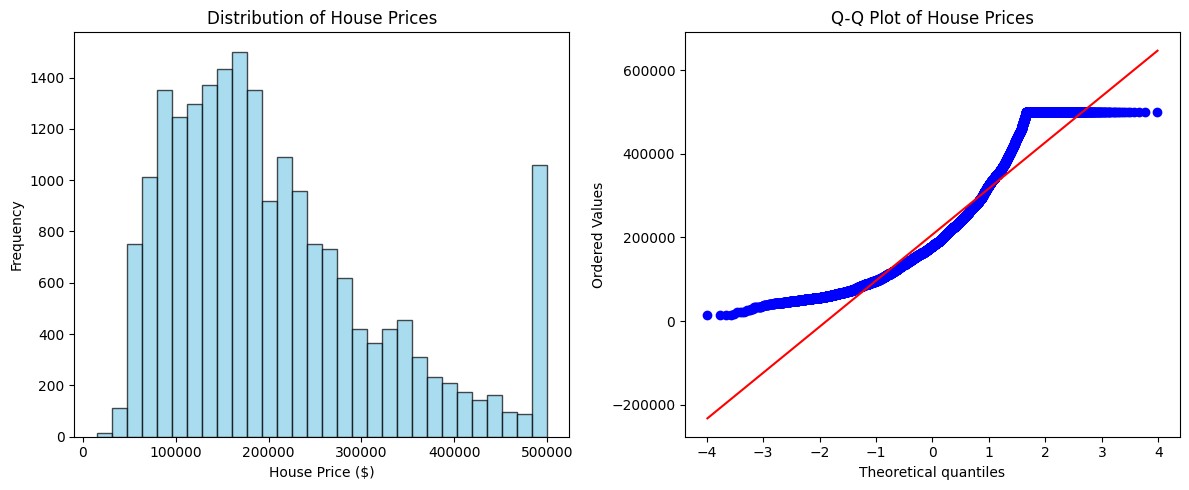

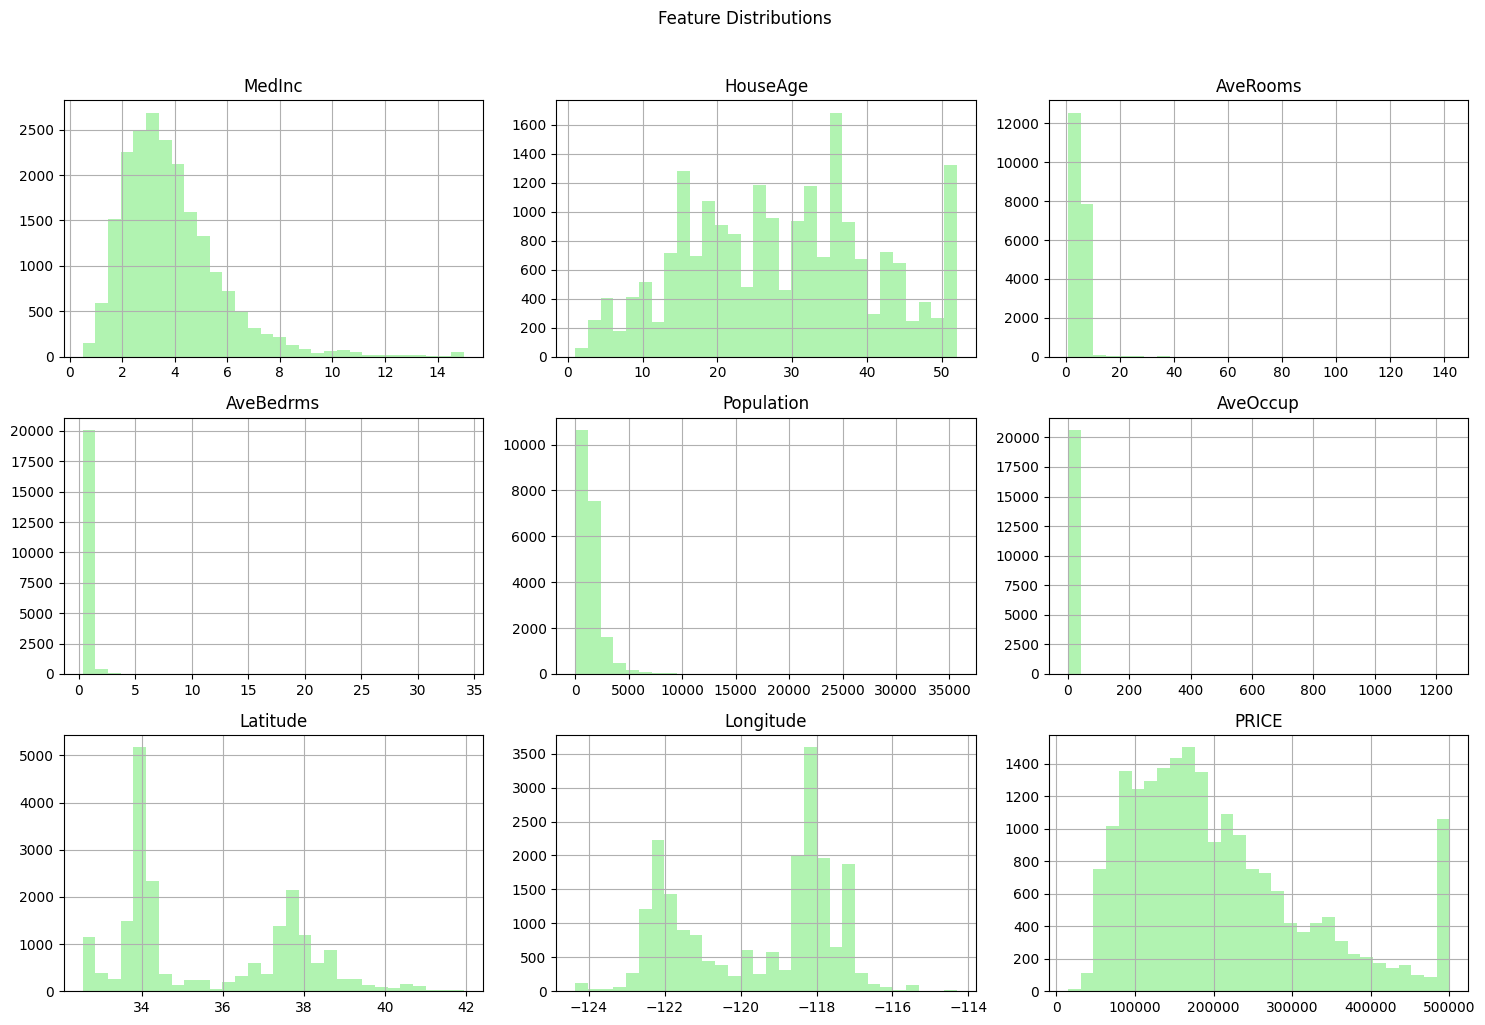

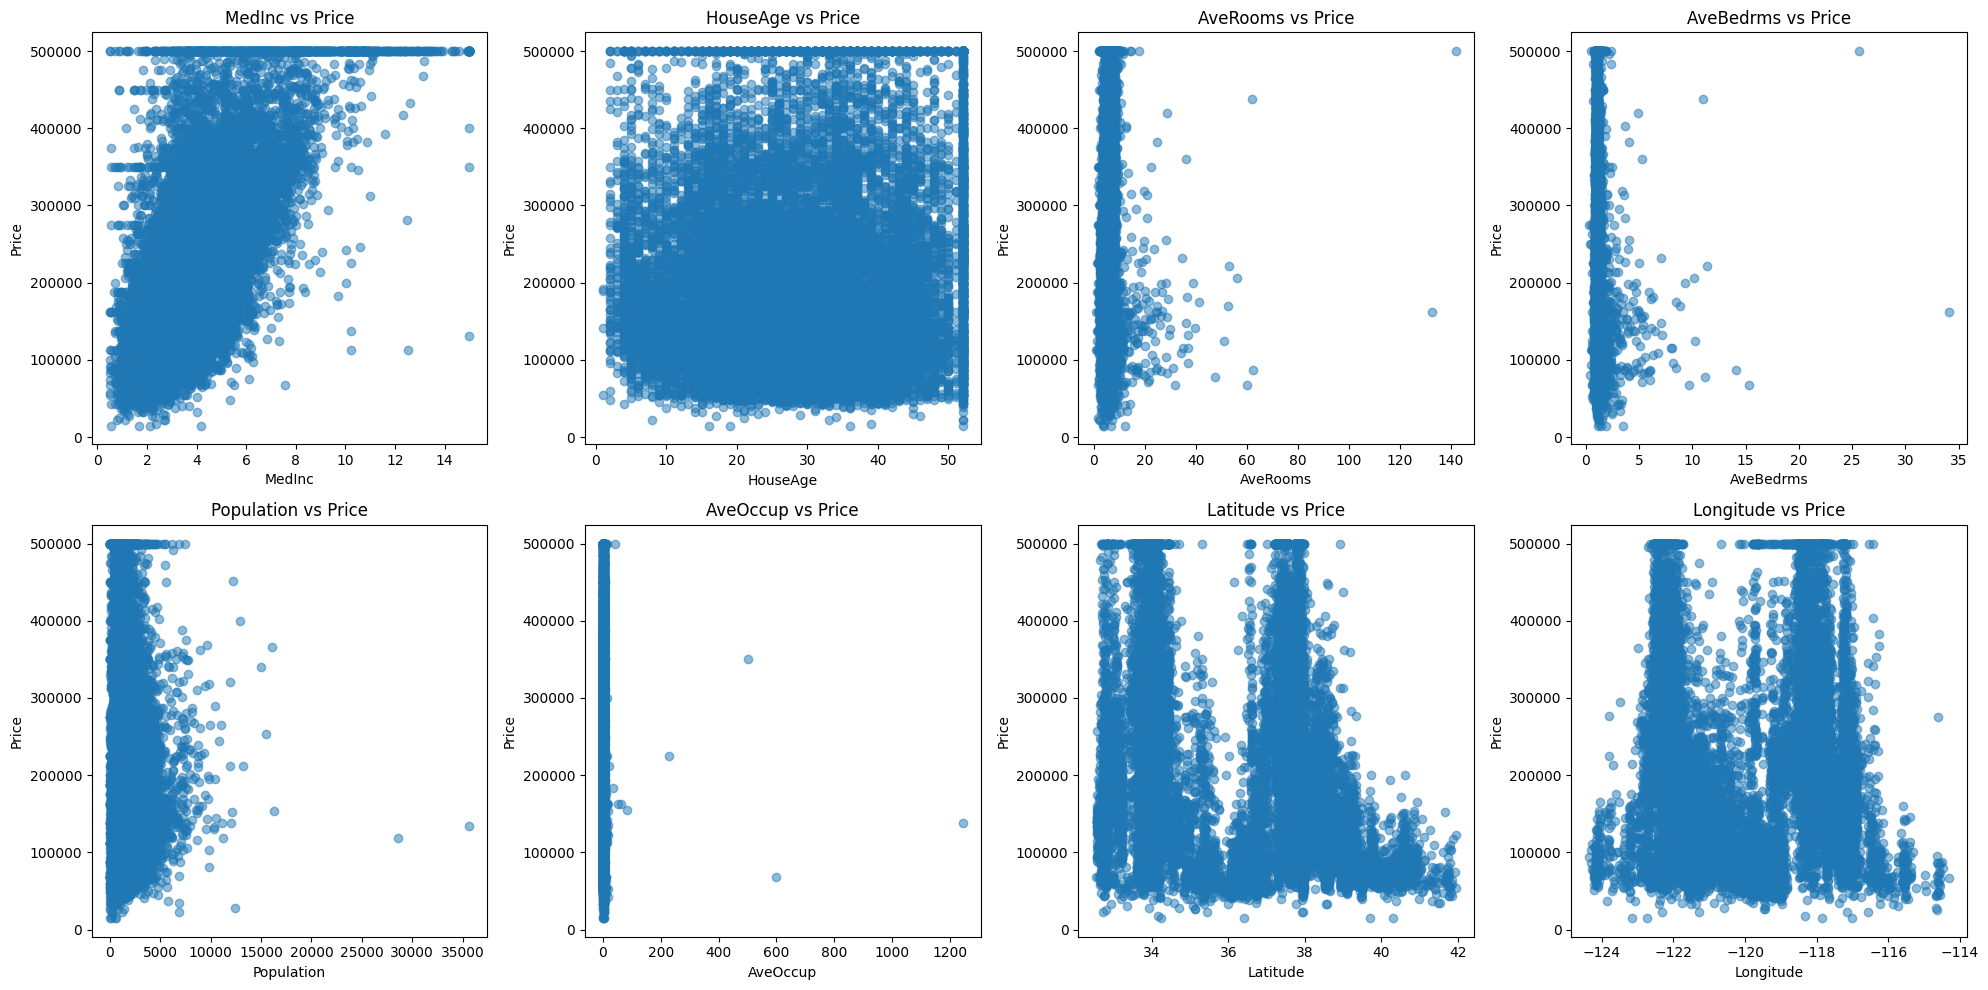


2. PREPROCESSING DATA
Preprocessing data...
Training set size: 16512
Test set size: 4128
Processed training set shape: (16512, 8)
Processed test set shape: (4128, 8)

3. TRAINING MODELS
Training regression models...
Training Models...
--------------------------------------------------
Training linear_regression...
linear_regression    | CV RMSE: 72060.0584
Training ridge...
ridge                | CV RMSE: 72060.0582
Training lasso...
lasso                | CV RMSE: 72059.5562
Training elastic_net...
elastic_net          | CV RMSE: 72492.9979
Training random_forest...
random_forest        | CV RMSE: 51054.6445
Training gradient_boosting...
gradient_boosting    | CV RMSE: 47493.2196
Training svr...
svr                  | CV RMSE: 88949.8199
--------------------------------------------------

4. EVALUATING MODELS
Evaluating models on test set...
------------------------------------------------------------

LINEAR_REGRESSION Performance:
  RMSE: $74,558.14
  MAE: $53,320.01
  R² Score: 0.

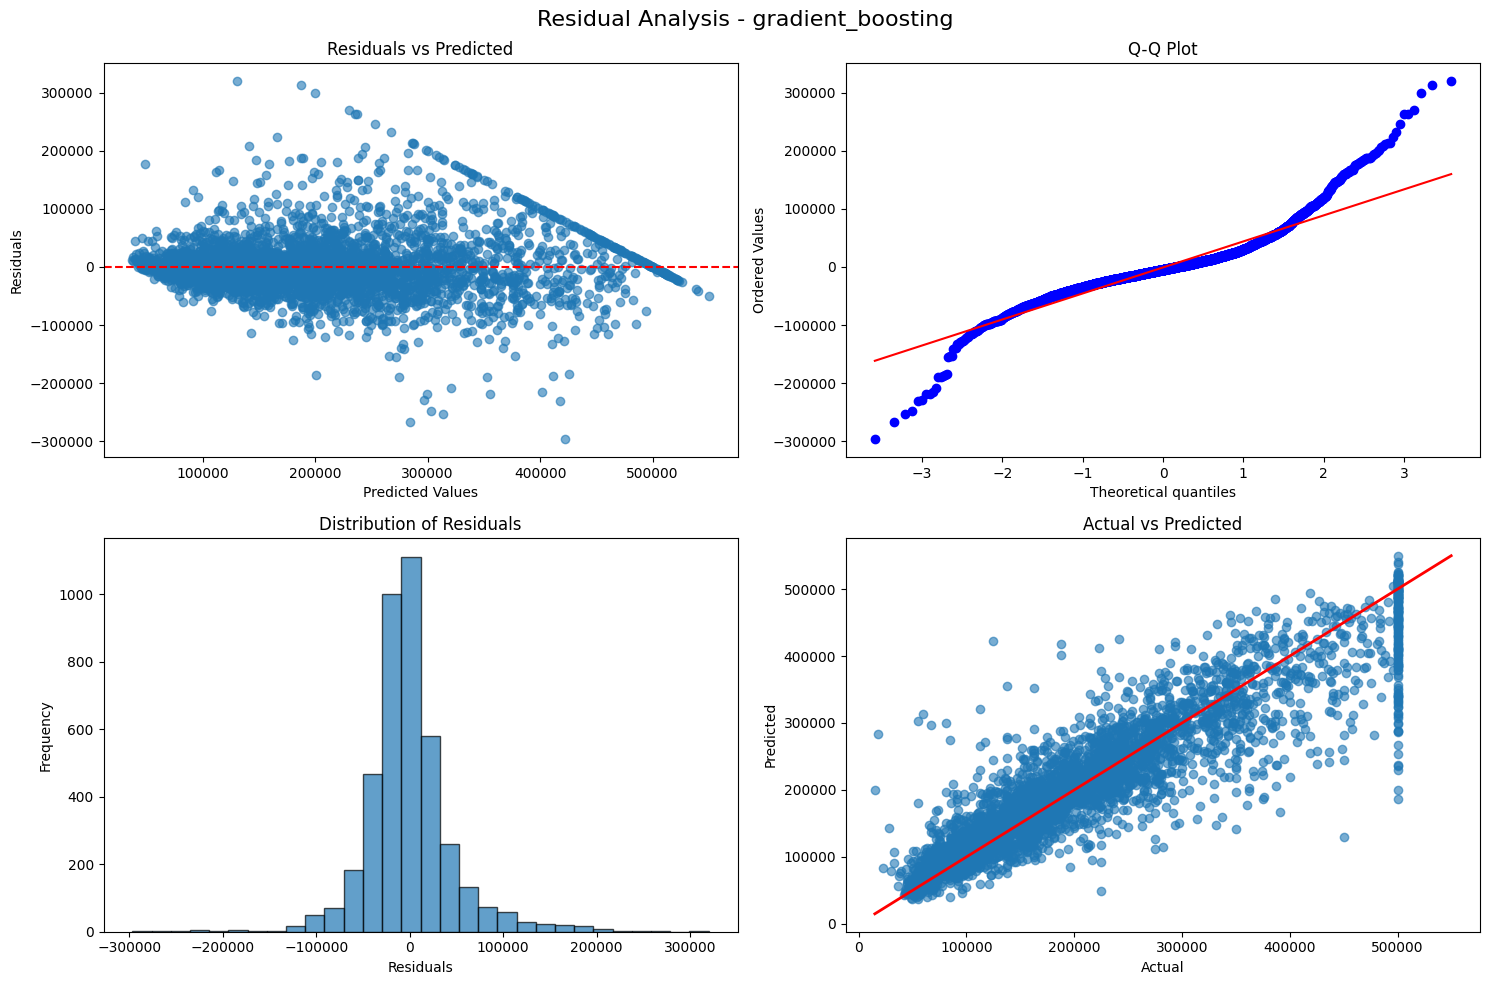


5. MODEL COMPARISON

Overall Model Performance (Sorted by RMSE):
                            MSE          RMSE           MAE        R2  \
gradient_boosting  2.237448e+09  47301.675381  31402.196376  0.829256   
random_forest      2.544868e+09  50446.686679  32674.133613  0.805796   
elastic_net        5.526451e+09  74340.104622  53566.478672  0.578265   
lasso              5.557451e+09  74548.313152  53319.225727  0.575900   
ridge              5.558879e+09  74557.891190  53319.941470  0.575791   
linear_regression  5.558916e+09  74558.138301  53320.013050  0.575788   
svr                7.518992e+09  86712.119509  62090.590006  0.426210   

                        MAPE  
gradient_boosting  18.241463  
random_forest      18.861044  
elastic_net        32.110214  
lasso              31.950291  
ridge              31.952085  
linear_regression  31.952187  
svr                35.773090  


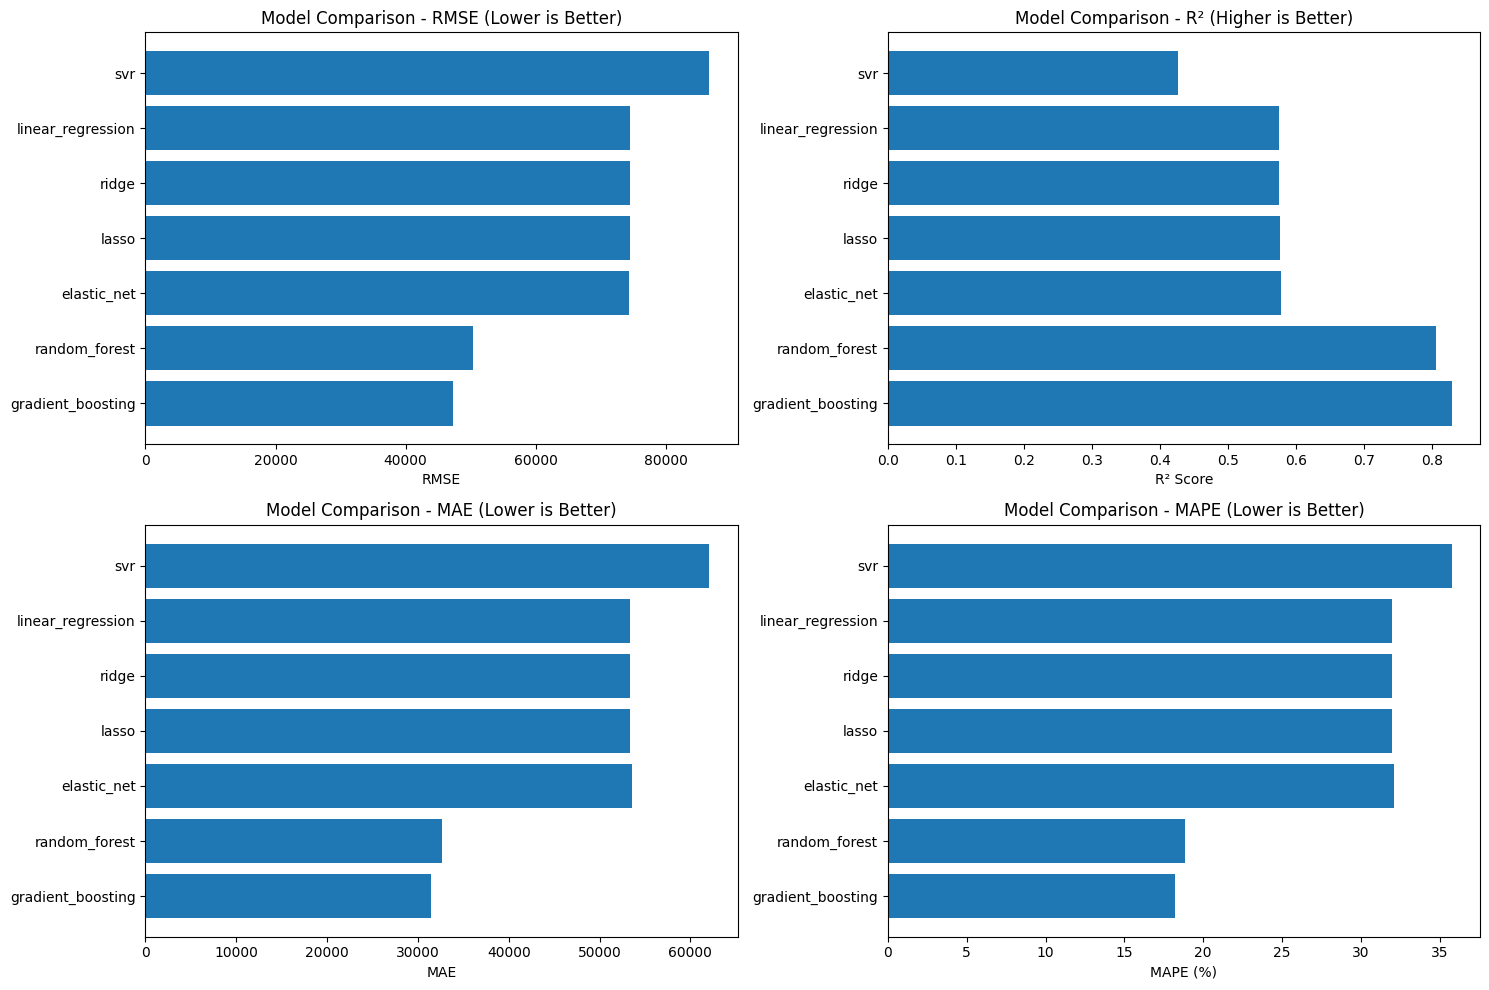


6. INTERPRETING BEST MODEL
Interpreting best model: gradient_boosting


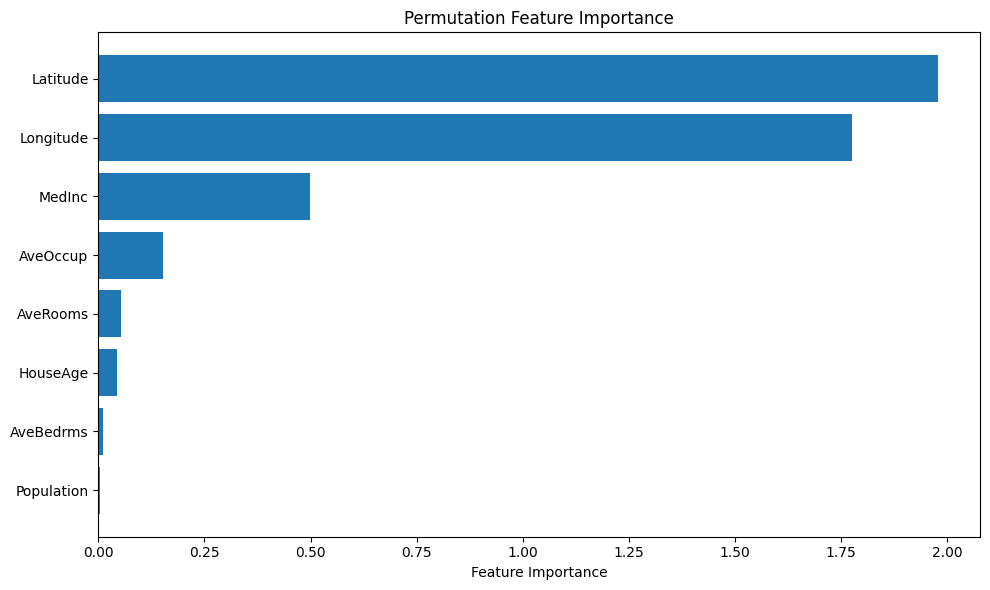


Feature Importance Ranking:
      feature  importance
6    Latitude    1.977964
7   Longitude    1.774794
0      MedInc    0.498307
5    AveOccup    0.152474
2    AveRooms    0.052699
1    HouseAge    0.044124
3   AveBedrms    0.011057
4  Population    0.004474

FINAL SUMMARY
Best Model: gradient_boosting
Best RMSE: $47,301.68
Best R² Score: 0.8293
Mean Absolute Error: $31,402.20
Mean Absolute Percentage Error: 18.24%

Sample Predictions (First 10 test samples):
   Actual Price  Predicted Price  Absolute Error  Percentage Error
0    $47,700.00       $47,510.36         189.64%             0.40%
1    $45,800.00       $96,274.98      $50,474.98           110.21%
2   $500,001.00      $488,512.37      $11,488.63             2.30%
3   $218,600.00      $242,187.74      $23,587.74            10.79%
4   $278,000.00      $237,411.59      $40,588.41            14.60%
5   $158,700.00      $171,797.30      $13,097.30             8.25%
6   $198,200.00      $237,999.34      $39,799.34            20.

In [ ]:
# Run the complete project
def quick_start():
    """Run the complete regression project with one function call"""
    print(" Starting Complete Regression Project...")

    # Initialize and run the housing price prediction project
    project = HousingPricePrediction()
    project.run_complete_analysis()

    print("\n Project completed successfully!")
    print("\n Key outputs generated:")
    print("   - Exploratory Data Analysis plots")
    print("   - Multiple regression models trained and evaluated")
    print("   - Model performance comparison")
    print("   - Best model interpretation")
    print("   - Residual analysis")
    print("   - Feature importance analysis")

# Run the entire project
quick_start()

Polynomial Regression

Polynomial Regression Demonstration


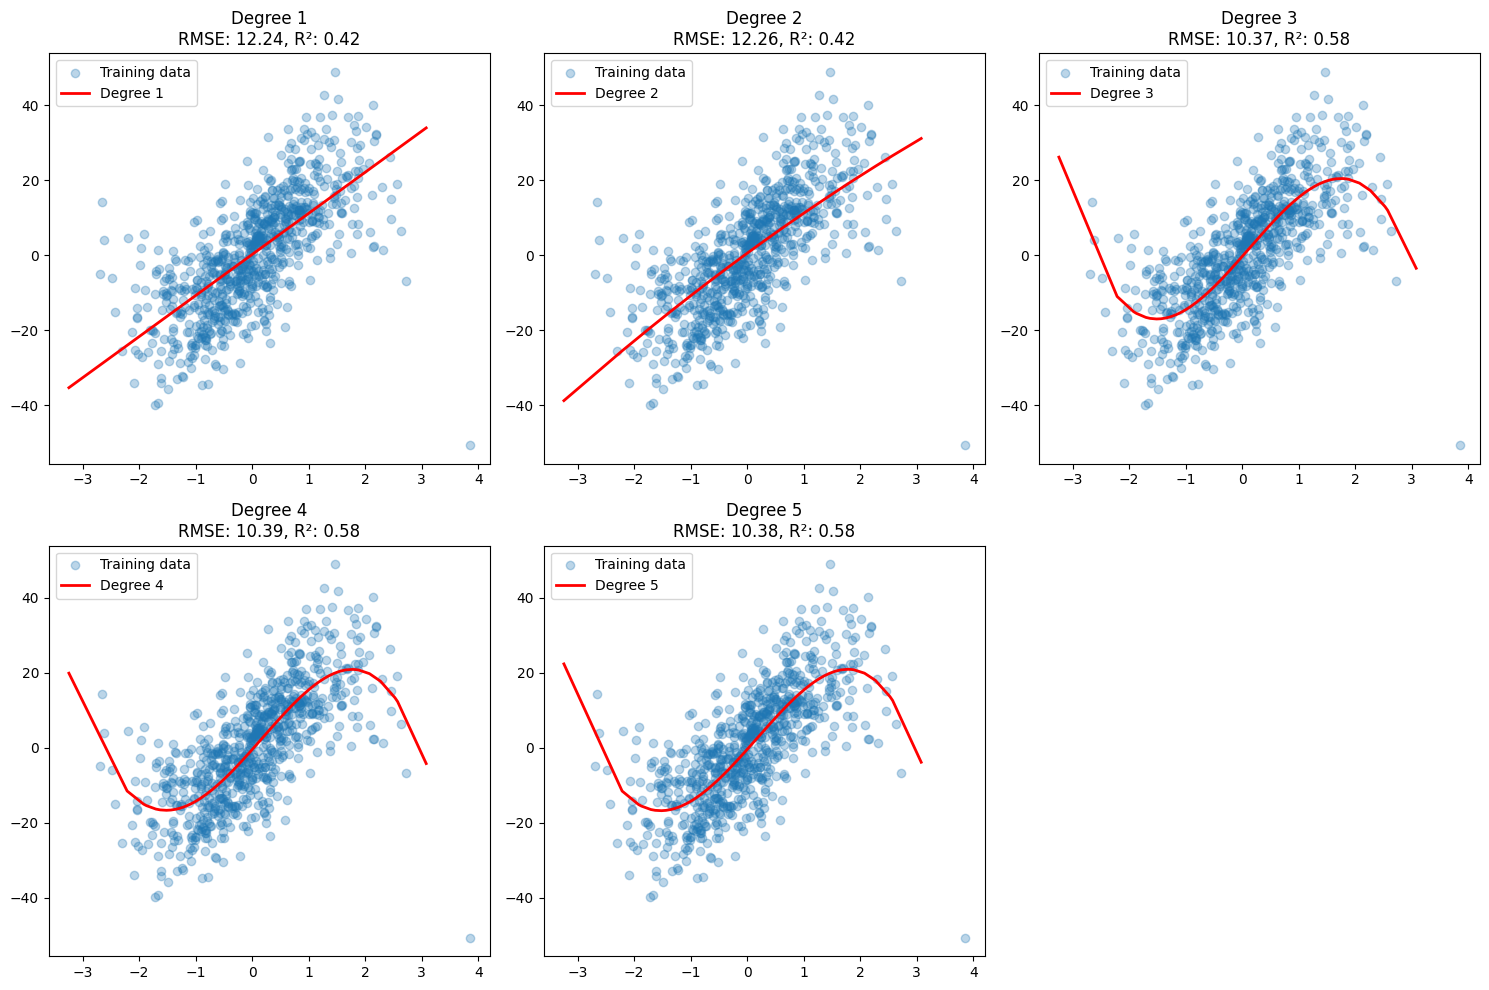


Polynomial Regression Results:


,RMSE,R2
1,12.241619,0.419138
2,12.264092,0.417003
3,10.365956,0.583501
4,10.389584,0.581600
5,10.375980,0.582695


In [ ]:
# Polynomial Regression Extension
def polynomial_regression_demo():
    """Demonstrate polynomial regression"""
    print("Polynomial Regression Demonstration")
    print("=" * 50)

    # Generate sample data
    X, y = make_regression(n_samples=1000, n_features=1, noise=10, random_state=42)
    X = X.flatten()

    # Add some non-linearity
    y = y + 0.5 * X**2 - 2 * X**3

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X.reshape(-1, 1), y, test_size=0.2, random_state=42
    )

    # Try different polynomial degrees
    degrees = [1, 2, 3, 4, 5]
    results = {}

    plt.figure(figsize=(15, 10))

    for i, degree in enumerate(degrees):
        # Create polynomial features
        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)

        # Train model
        model = LinearRegression()
        model.fit(X_train_poly, y_train)

        # Make predictions
        y_pred = model.predict(X_test_poly)

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        results[degree] = {'RMSE': rmse, 'R2': r2}

        # Plot
        plt.subplot(2, 3, i+1)

        # Sort for smooth curve
        sort_idx = np.argsort(X_test.flatten())
        X_sorted = X_test.flatten()[sort_idx]
        y_pred_sorted = y_pred[sort_idx]

        plt.scatter(X_train, y_train, alpha=0.3, label='Training data')
        plt.plot(X_sorted, y_pred_sorted, 'r-', label=f'Degree {degree}', linewidth=2)
        plt.title(f'Degree {degree}\nRMSE: {rmse:.2f}, R²: {r2:.2f}')
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Compare results
    results_df = pd.DataFrame(results).T
    print("\nPolynomial Regression Results:")
    display(results_df)

    return results_df

# Run polynomial regression demo
polynomial_results = polynomial_regression_demo()

# **Advanced: Cross-Validation Results Visualization**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import cross_validate, learning_curve, validation_curve
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

class AdvancedCrossValidationVisualizer:
    def __init__(self):
        self.cv_results = {}

    def comprehensive_cross_validation(self, models, X, y, cv=5, scoring=None):
        """Perform comprehensive cross-validation with multiple metrics"""
        if scoring is None:
            scoring = {
                'neg_mse': 'neg_mean_squared_error',
                'neg_mae': 'neg_mean_absolute_error',
                'r2': 'r2',
                'explained_variance': 'explained_variance'
            }

        cv_results = {}

        for name, model in models.items():
            print(f"Running comprehensive CV for {name}...")

            # Perform cross-validation with multiple metrics
            scores = cross_validate(
                model, X, y,
                cv=cv,
                scoring=scoring,
                return_train_score=True,
                n_jobs=-1
            )

            cv_results[name] = scores

        self.cv_results = cv_results
        return cv_results

    def plot_cv_metrics_comparison(self):
        """Create comprehensive CV metrics comparison"""
        if not self.cv_results:
            print("No CV results available. Run comprehensive_cross_validation first.")
            return

        metrics = ['test_neg_mse', 'test_neg_mae', 'test_r2', 'test_explained_variance']
        metric_names = ['Negative MSE', 'Negative MAE', 'R² Score', 'Explained Variance']

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.ravel()

        for idx, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
            # Prepare data
            model_names = []
            metric_values = []

            for model_name, scores in self.cv_results.items():
                model_names.append(model_name)
                metric_values.append(scores[metric])

            # Create box plot
            box_plot = axes[idx].boxplot(metric_values, labels=model_names, patch_artist=True)

            # Customize colors
            colors = plt.cm.Set3(np.linspace(0, 1, len(model_names)))
            for patch, color in zip(box_plot['boxes'], colors):
                patch.set_facecolor(color)

            axes[idx].set_title(f'Cross-Validation: {metric_name}', fontsize=14, fontweight='bold')
            axes[idx].set_ylabel(metric_name)
            axes[idx].tick_params(axis='x', rotation=45)
            axes[idx].grid(True, alpha=0.3)

            # Add mean values as text
            for i, values in enumerate(metric_values):
                mean_val = np.mean(values)
                axes[idx].text(i + 1, mean_val, f'{mean_val:.3f}',
                             ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.show()

    def plot_learning_curves(self, models, X, y, cv=5, train_sizes=None):
        """Plot learning curves for multiple models"""
        if train_sizes is None:
            train_sizes = np.linspace(0.1, 1.0, 10)

        n_models = len(models)
        fig, axes = plt.subplots(2, n_models, figsize=(6 * n_models, 10))

        if n_models == 1:
            axes = axes.reshape(2, 1)

        for idx, (model_name, model) in enumerate(models.items()):
            print(f"Generating learning curve for {model_name}...")

            # Calculate learning curve
            train_sizes_abs, train_scores, test_scores = learning_curve(
                model, X, y,
                cv=cv,
                train_sizes=train_sizes,
                scoring='neg_mean_squared_error',
                n_jobs=-1,
                random_state=42
            )

            # Calculate mean and std
            train_scores_mean = -np.mean(train_scores, axis=1)
            train_scores_std = np.std(train_scores, axis=1)
            test_scores_mean = -np.mean(test_scores, axis=1)
            test_scores_std = np.std(test_scores, axis=1)

            # Plot learning curve
            axes[0, idx].fill_between(train_sizes_abs,
                                    train_scores_mean - train_scores_std,
                                    train_scores_mean + train_scores_std,
                                    alpha=0.1, color="r")
            axes[0, idx].fill_between(train_sizes_abs,
                                    test_scores_mean - test_scores_std,
                                    test_scores_mean + test_scores_std,
                                    alpha=0.1, color="g")
            axes[0, idx].plot(train_sizes_abs, train_scores_mean, 'o-', color="r",
                            label="Training score")
            axes[0, idx].plot(train_sizes_abs, test_scores_mean, 'o-', color="g",
                            label="Cross-validation score")
            axes[0, idx].set_xlabel("Training examples")
            axes[0, idx].set_ylabel("MSE")
            axes[0, idx].set_title(f"Learning Curve: {model_name}")
            axes[0, idx].legend(loc="best")
            axes[0, idx].grid(True, alpha=0.3)

            # Plot training vs test score difference
            score_gap = train_scores_mean - test_scores_mean
            axes[1, idx].plot(train_sizes_abs, score_gap, 'o-', color="purple")
            axes[1, idx].set_xlabel("Training examples")
            axes[1, idx].set_ylabel("Train - Test MSE Gap")
            axes[1, idx].set_title(f"Overfitting Gap: {model_name}")
            axes[1, idx].grid(True, alpha=0.3)
            axes[1, idx].axhline(y=0, color='red', linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.show()

    def plot_validation_curves(self, models_with_params, X, y, cv=5):
        """Plot validation curves for hyperparameter tuning analysis"""
        n_models = len(models_with_params)
        fig, axes = plt.subplots(2, n_models, figsize=(6 * n_models, 10))

        if n_models == 1:
            axes = axes.reshape(2, 1)

        for idx, (model_name, model_info) in enumerate(models_with_params.items()):
            model = model_info['model']
            param_name = model_info['param_name']
            param_range = model_info['param_range']

            print(f"Generating validation curve for {model_name} - {param_name}...")

            # Calculate validation curve
            train_scores, test_scores = validation_curve(
                model, X, y,
                param_name=param_name,
                param_range=param_range,
                cv=cv,
                scoring="neg_mean_squared_error",
                n_jobs=-1
            )

            train_scores_mean = -np.mean(train_scores, axis=1)
            train_scores_std = np.std(train_scores, axis=1)
            test_scores_mean = -np.mean(test_scores, axis=1)
            test_scores_std = np.std(test_scores, axis=1)

            # Plot validation curve
            axes[0, idx].plot(param_range, train_scores_mean, label="Training score", color="darkorange", lw=2)
            axes[0, idx].plot(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=2)
            axes[0, idx].fill_between(param_range, train_scores_mean - train_scores_std,
                                    train_scores_mean + train_scores_std, alpha=0.2, color="darkorange")
            axes[0, idx].fill_between(param_range, test_scores_mean - test_scores_std,
                                    test_scores_mean + test_scores_std, alpha=0.2, color="navy")
            axes[0, idx].set_xlabel(param_name)
            axes[0, idx].set_ylabel("MSE")
            axes[0, idx].set_title(f"Validation Curve: {model_name}")
            axes[0, idx].legend(loc="best")
            axes[0, idx].grid(True, alpha=0.3)

            # Plot score difference
            score_diff = test_scores_mean - train_scores_mean
            axes[1, idx].plot(param_range, score_diff, 'o-', color="red", lw=2)
            axes[1, idx].set_xlabel(param_name)
            axes[1, idx].set_ylabel("Test - Train MSE Difference")
            axes[1, idx].set_title(f"Generalization Gap: {model_name}")
            axes[1, idx].grid(True, alpha=0.3)
            axes[1, idx].axhline(y=0, color='black', linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.show()

    def plot_interactive_cv_dashboard(self):
        """Create an interactive dashboard using Plotly"""
        if not self.cv_results:
            print("No CV results available.")
            return

        # Prepare data for interactive plots
        metrics_data = []

        for model_name, scores in self.cv_results.items():
            for metric in ['test_neg_mse', 'test_neg_mae', 'test_r2']:
                for fold_idx, score in enumerate(scores[metric]):
                    metrics_data.append({
                        'Model': model_name,
                        'Metric': metric.replace('test_', '').upper(),
                        'Score': score,
                        'Fold': fold_idx + 1
                    })

        df = pd.DataFrame(metrics_data)

        # Create interactive subplots
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('MSE Distribution', 'MAE Distribution',
                          'R² Distribution', 'Model Comparison'),
            specs=[[{"type": "box"}, {"type": "box"}],
                   [{"type": "bar"}, {"type": "scatter"}]]
        )

        # Box plots for MSE
        mse_data = df[df['Metric'] == 'NEG_MSE']
        for model in mse_data['Model'].unique():
            model_data = mse_data[mse_data['Model'] == model]
            fig.add_trace(
                go.Box(y=model_data['Score'], name=model,
                      legendgroup=model, showlegend=False),
                row=1, col=1
            )

        # Box plots for MAE
        mae_data = df[df['Metric'] == 'NEG_MAE']
        for model in mae_data['Model'].unique():
            model_data = mae_data[mae_data['Model'] == model]
            fig.add_trace(
                go.Box(y=model_data['Score'], name=model,
                      legendgroup=model, showlegend=False),
                row=1, col=2
            )

        # Bar chart for R² scores
        r2_means = df[df['Metric'] == 'R2'].groupby('Model')['Score'].mean().reset_index()
        fig.add_trace(
            go.Bar(x=r2_means['Model'], y=r2_means['Score'],
                  marker_color=px.colors.qualitative.Set3),
            row=2, col=1
        )

        # Scatter plot for model comparison
        summary_data = []
        for model in df['Model'].unique():
            model_mse = df[(df['Model'] == model) & (df['Metric'] == 'NEG_MSE')]['Score'].mean()
            model_r2 = df[(df['Model'] == model) & (df['Metric'] == 'R2')]['Score'].mean()
            summary_data.append({'Model': model, 'MSE': -model_mse, 'R2': model_r2})

        summary_df = pd.DataFrame(summary_data)
        fig.add_trace(
            go.Scatter(x=summary_df['MSE'], y=summary_df['R2'],
                      text=summary_df['Model'], mode='markers+text',
                      marker=dict(size=20, color=summary_df['R2'],
                                colorscale='Viridis', showscale=True),
                      textposition="top center"),
            row=2, col=2
        )

        fig.update_layout(height=800, title_text="Interactive Cross-Validation Dashboard")
        fig.show()

    def create_cv_summary_table(self):
        """Create a comprehensive summary table of CV results"""
        if not self.cv_results:
            print("No CV results available.")
            return None

        summary_data = []

        for model_name, scores in self.cv_results.items():
            row = {'Model': model_name}

            for metric in ['test_neg_mse', 'test_neg_mae', 'test_r2', 'test_explained_variance']:
                mean_score = np.mean(scores[metric])
                std_score = np.std(scores[metric])

                if 'neg' in metric:
                    # Convert negative scores to positive and format
                    display_metric = metric.replace('test_neg_', '').upper()
                    mean_score = -mean_score
                    row[f'{display_metric} Mean'] = f"{mean_score:.4f}"
                    row[f'{display_metric} Std'] = f"{std_score:.4f}"
                else:
                    display_metric = metric.replace('test_', '').upper()
                    row[f'{display_metric} Mean'] = f"{mean_score:.4f}"
                    row[f'{display_metric} Std'] = f"{std_score:.4f}"

            # Calculate train-test gap
            train_mse = -np.mean(scores['train_neg_mse'])
            test_mse = -np.mean(scores['test_neg_mse'])
            row['Train-Test Gap'] = f"{(train_mse - test_mse):.4f}"

            summary_data.append(row)

        summary_df = pd.DataFrame(summary_data)
        return summary_df

    def plot_cv_fold_analysis(self):
        """Analyze performance across different folds"""
        if not self.cv_results:
            print("No CV results available.")
            return

        # Prepare data for fold analysis
        fold_data = []

        for model_name, scores in self.cv_results.items():
            for fold_idx in range(len(scores['test_neg_mse'])):
                fold_data.append({
                    'Model': model_name,
                    'Fold': fold_idx + 1,
                    'MSE': -scores['test_neg_mse'][fold_idx],
                    'R2': scores['test_r2'][fold_idx],
                    'MAE': -scores['test_neg_mae'][fold_idx]
                })

        df = pd.DataFrame(fold_data)

        # Create fold analysis plot
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # MSE across folds
        for model in df['Model'].unique():
            model_data = df[df['Model'] == model]
            axes[0, 0].plot(model_data['Fold'], model_data['MSE'], 'o-', label=model)
        axes[0, 0].set_xlabel('Fold')
        axes[0, 0].set_ylabel('MSE')
        axes[0, 0].set_title('MSE Across CV Folds')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # R² across folds
        for model in df['Model'].unique():
            model_data = df[df['Model'] == model]
            axes[0, 1].plot(model_data['Fold'], model_data['R2'], 'o-', label=model)
        axes[0, 1].set_xlabel('Fold')
        axes[0, 1].set_ylabel('R² Score')
        axes[0, 1].set_title('R² Score Across CV Folds')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # Performance stability (coefficient of variation)
        stability_data = []
        for model in df['Model'].unique():
            model_data = df[df['Model'] == model]
            cv_mse = np.std(model_data['MSE']) / np.mean(model_data['MSE'])
            cv_r2 = np.std(model_data['R2']) / np.mean(model_data['R2'])
            stability_data.append({'Model': model, 'CV_MSE': cv_mse, 'CV_R2': cv_r2})

        stability_df = pd.DataFrame(stability_data)
        x_pos = np.arange(len(stability_df))

        axes[1, 0].bar(x_pos - 0.2, stability_df['CV_MSE'], 0.4, label='MSE CV', alpha=0.7)
        axes[1, 0].bar(x_pos + 0.2, stability_df['CV_R2'], 0.4, label='R² CV', alpha=0.7)
        axes[1, 0].set_xlabel('Model')
        axes[1, 0].set_ylabel('Coefficient of Variation')
        axes[1, 0].set_title('Model Performance Stability')
        axes[1, 0].set_xticks(x_pos)
        axes[1, 0].set_xticklabels(stability_df['Model'], rotation=45)
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # Best performing fold for each model
        best_folds = []
        for model in df['Model'].unique():
            model_data = df[df['Model'] == model]
            best_fold = model_data.loc[model_data['R2'].idxmax()]
            best_folds.append(best_fold)

        best_folds_df = pd.DataFrame(best_folds)
        axes[1, 1].scatter(best_folds_df['Model'], best_folds_df['R2'],
                          s=100, alpha=0.7, color='green')
        axes[1, 1].set_xlabel('Model')
        axes[1, 1].set_ylabel('Best R² Score')
        axes[1, 1].set_title('Best Performing Fold for Each Model')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        return df

# Example usage and integration with your existing project
def demonstrate_advanced_cv_visualization(X, y, models):
    """Demonstrate all advanced CV visualization techniques"""

    visualizer = AdvancedCrossValidationVisualizer()

    print("🔬 ADVANCED CROSS-VALIDATION VISUALIZATION")
    print("=" * 60)

    # 1. Comprehensive Cross-Validation
    print("\n1. Running Comprehensive Cross-Validation...")
    cv_results = visualizer.comprehensive_cross_validation(models, X, y, cv=5)

    # 2. CV Metrics Comparison
    print("\n2. Generating CV Metrics Comparison...")
    visualizer.plot_cv_metrics_comparison()

    # 3. Learning Curves
    print("\n3. Generating Learning Curves...")
    # Use a subset of models for learning curves to avoid clutter
    selected_models = dict(list(models.items())[:3])  # First 3 models
    visualizer.plot_learning_curves(selected_models, X, y)

    # 4. Validation Curves (for specific models with hyperparameters)
    print("\n4. Generating Validation Curves...")
    validation_models = {
        'Random Forest': {
            'model': RandomForestRegressor(random_state=42),
            'param_name': 'n_estimators',
            'param_range': [10, 50, 100, 200]
        },
        'Gradient Boosting': {
            'model': GradientBoostingRegressor(random_state=42),
            'param_name': 'n_estimators',
            'param_range': [10, 50, 100, 200]
        }
    }
    visualizer.plot_validation_curves(validation_models, X, y)

    # 5. CV Fold Analysis
    print("\n5. Analyzing Performance Across Folds...")
    fold_analysis_df = visualizer.plot_cv_fold_analysis()

    # 6. Summary Table
    print("\n6. Generating Comprehensive Summary Table...")
    summary_table = visualizer.create_cv_summary_table()
    if summary_table is not None:
        print("\nCross-Validation Summary:")
        print(summary_table.to_string(index=False))

    # 7. Interactive Dashboard (if Plotly is available)
    try:
        print("\n7. Generating Interactive Dashboard...")
        visualizer.plot_interactive_cv_dashboard()
    except ImportError:
        print("Plotly not available for interactive dashboard")

    return visualizer, cv_results, summary_table

# Integration with your existing HousingPricePrediction class
def add_advanced_cv_to_project(project):
    """Add advanced CV visualization to existing project"""

    print("\n" + "="*70)
    print("INTEGRATING ADVANCED CROSS-VALIDATION VISUALIZATION")
    print("="*70)

    # Prepare models for CV analysis
    models_for_cv = {}
    for model_name, model_info in project.models.items():
        models_for_cv[model_name] = model_info['model']

    # Run advanced CV visualization
    cv_visualizer, cv_results, summary_table = demonstrate_advanced_cv_visualization(
        project.X_train_processed, project.y_train, models_for_cv
    )

    # Add CV results to project
    project.cv_visualizer = cv_visualizer
    project.cv_results = cv_results
    project.cv_summary_table = summary_table

    return cv_visualizer

# Quick test function
def test_advanced_cv():
    """Quick test of advanced CV visualization"""
    from sklearn.datasets import make_regression
    from sklearn.linear_model import LinearRegression, Ridge
    from sklearn.ensemble import RandomForestRegressor

    # Generate sample data
    X, y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)

    # Define models
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Random Forest': RandomForestRegressor(n_estimators=50, random_state=42)
    }

    # Run advanced CV visualization
    visualizer = AdvancedCrossValidationVisualizer()
    cv_results = visualizer.comprehensive_cross_validation(models, X, y, cv=5)
    visualizer.plot_cv_metrics_comparison()
    visualizer.plot_learning_curves(models, X, y)

    summary_table = visualizer.create_cv_summary_table()
    print("Summary Table:")
    print(summary_table)


test_advanced_cv()

COMPREHENSIVE REGRESSION ANALYSIS: HOUSING PRICE PREDICTION

1. LOADING AND EXPLORING DATA
Loading California Housing Dataset...
Dataset Shape: (20640, 9)

Dataset Description:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude          PRICE  
count  20640.000000  20640.000000  20640.00000

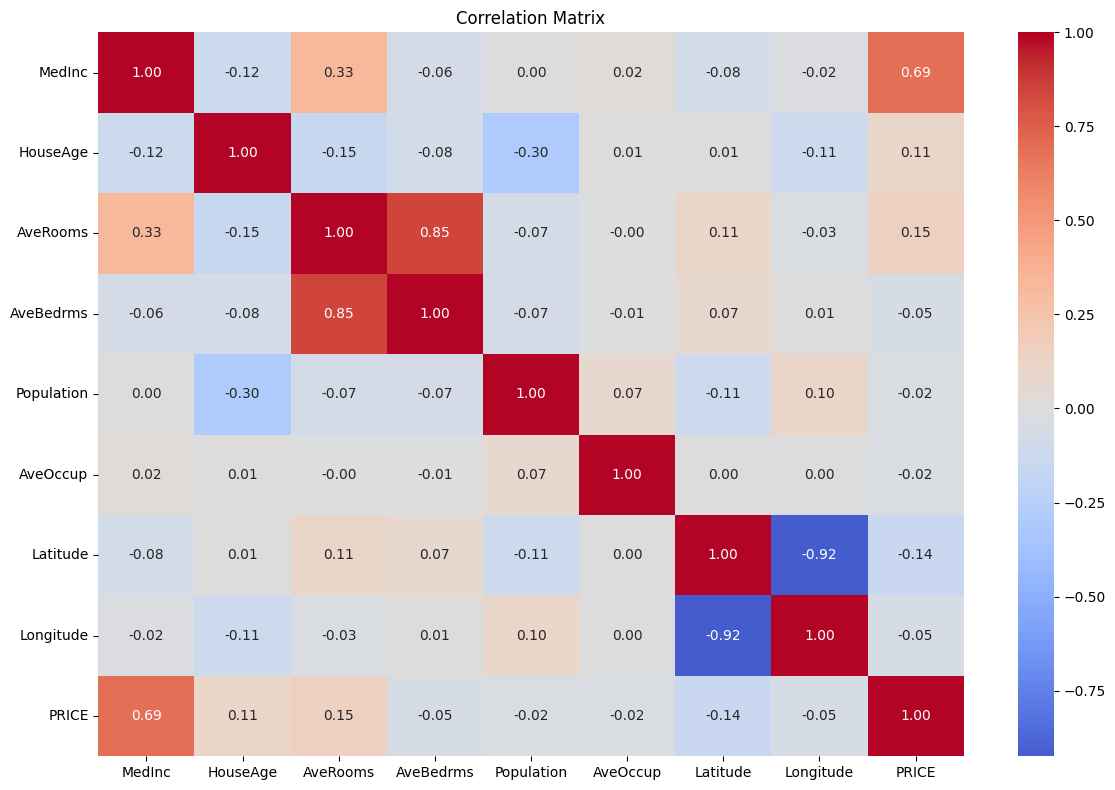

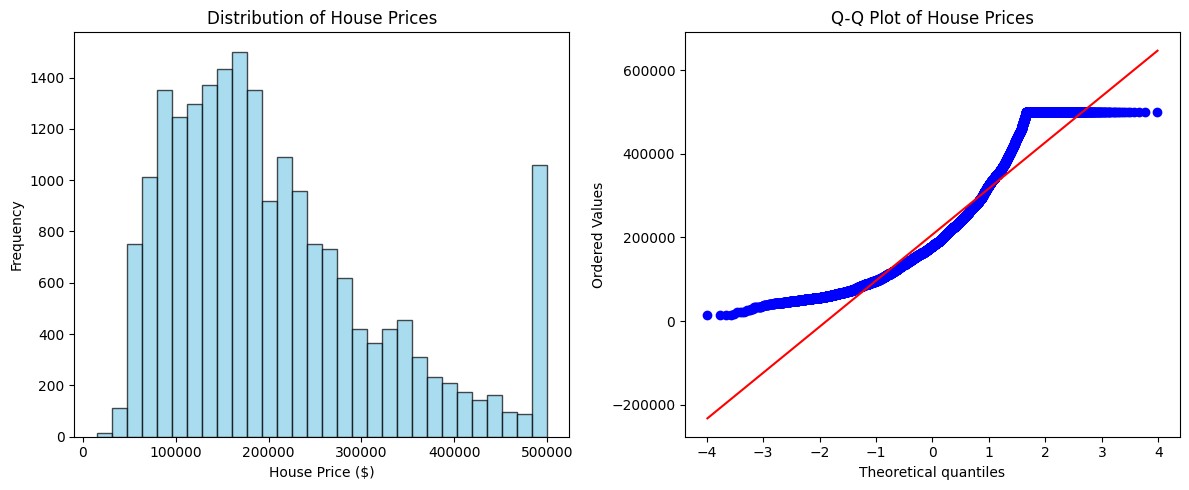

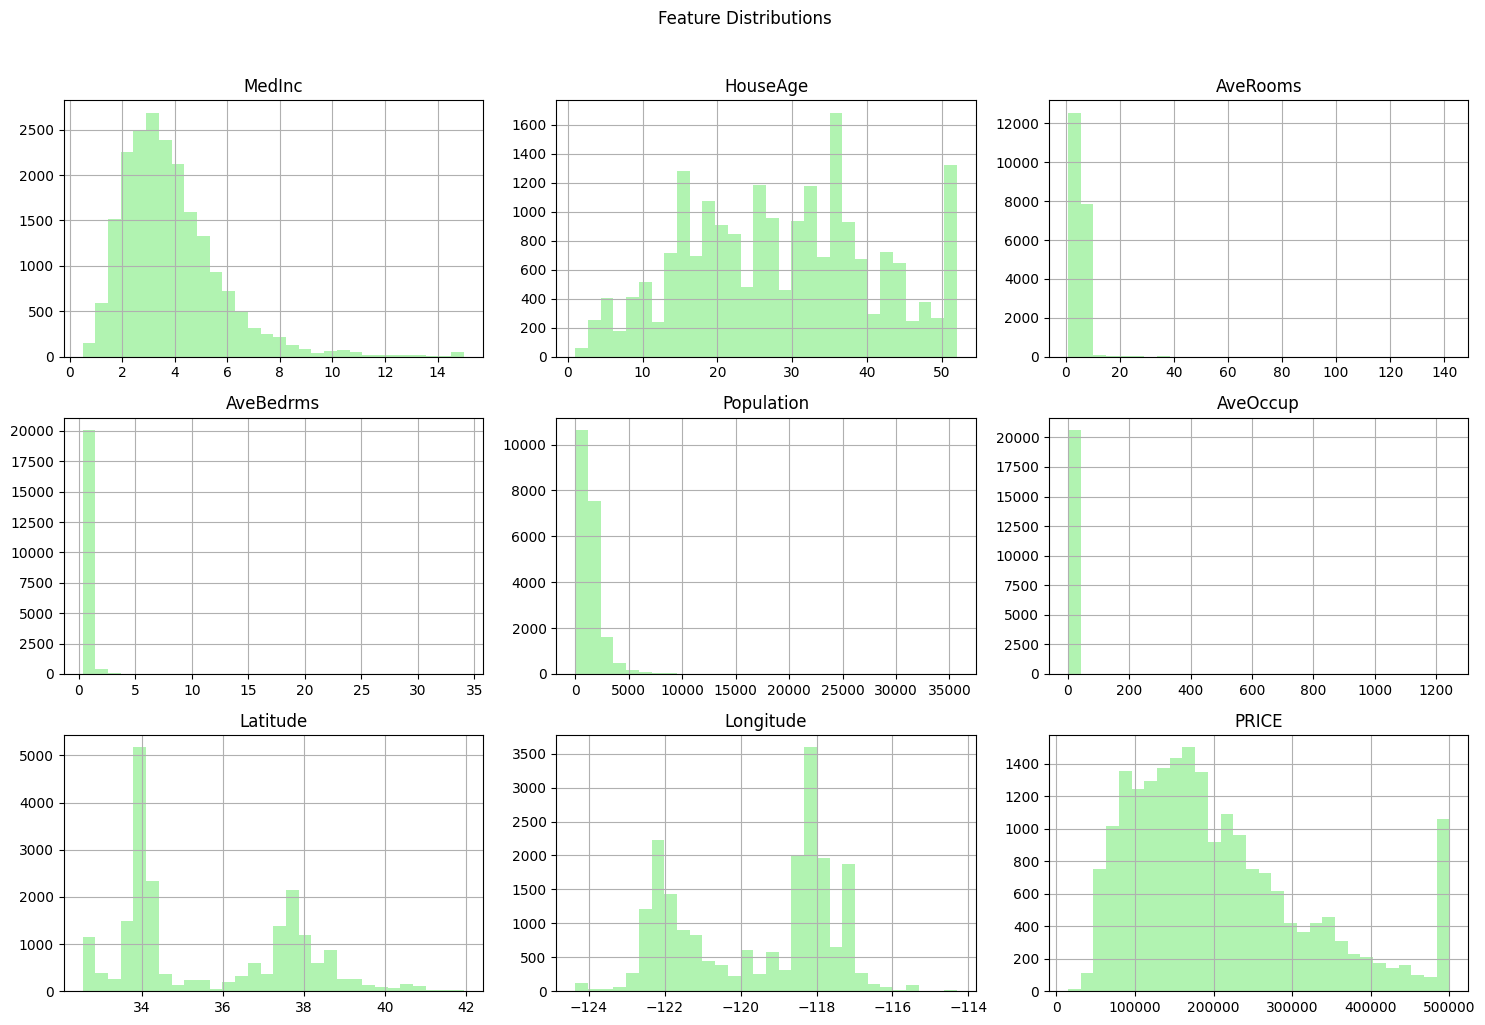

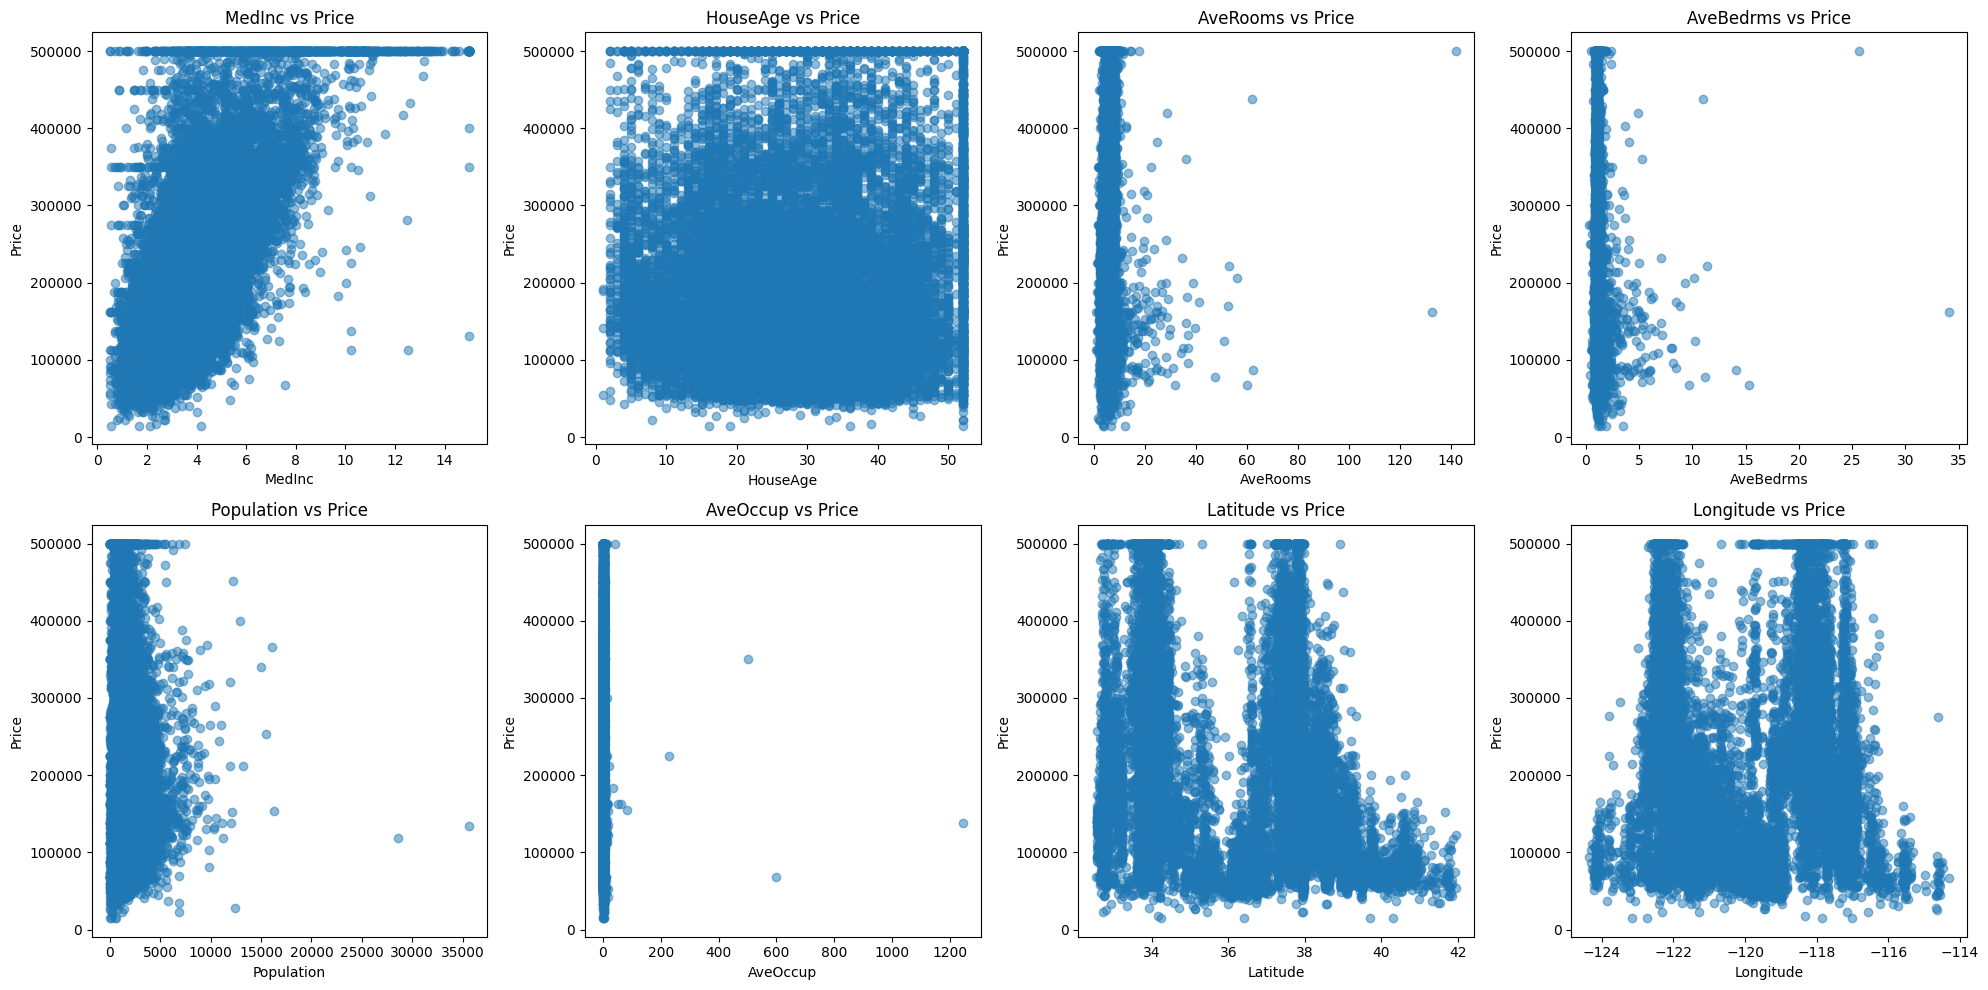


2. PREPROCESSING DATA
Preprocessing data...
Training set size: 16512
Test set size: 4128
Processed training set shape: (16512, 8)
Processed test set shape: (4128, 8)

3. TRAINING MODELS
Training regression models...
Training Models...
--------------------------------------------------
Training linear_regression...
linear_regression    | CV RMSE: 72060.0584
Training ridge...
ridge                | CV RMSE: 72060.0582
Training lasso...
lasso                | CV RMSE: 72059.5562
Training elastic_net...
elastic_net          | CV RMSE: 72492.9979
Training random_forest...
random_forest        | CV RMSE: 51054.6445
Training gradient_boosting...
gradient_boosting    | CV RMSE: 47493.2196
Training svr...
svr                  | CV RMSE: 88949.8199
--------------------------------------------------

4. EVALUATING MODELS
Evaluating models on test set...
------------------------------------------------------------

LINEAR_REGRESSION Performance:
  RMSE: $74,558.14
  MAE: $53,320.01
  R² Score: 0.

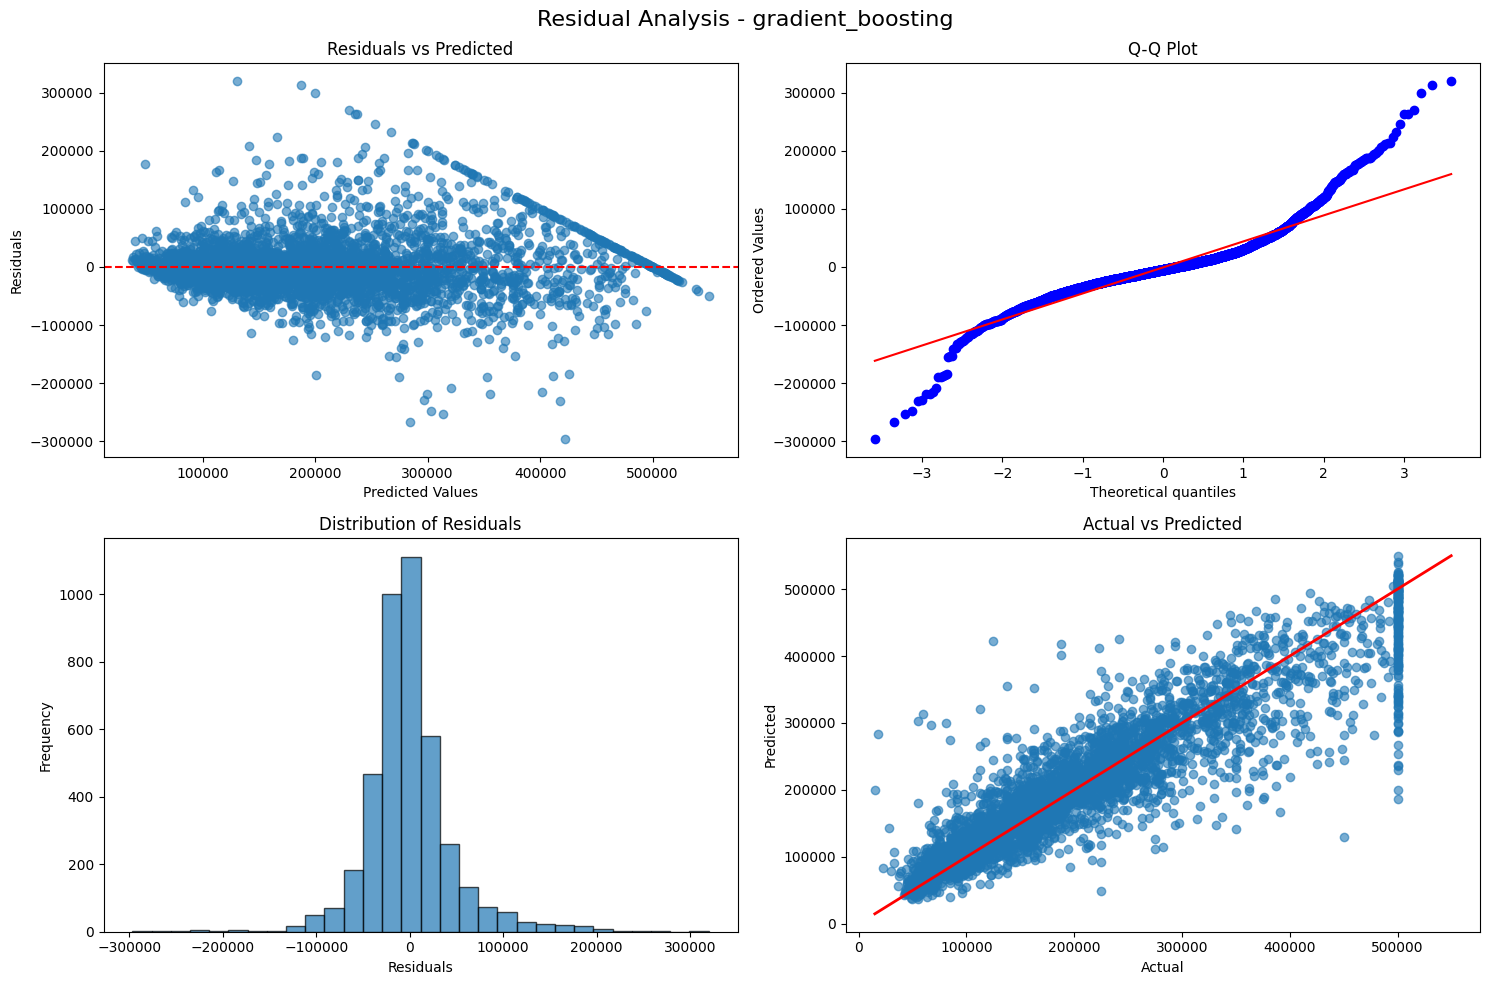


5. MODEL COMPARISON

Overall Model Performance (Sorted by RMSE):
                            MSE          RMSE           MAE        R2  \
gradient_boosting  2.237448e+09  47301.675381  31402.196376  0.829256   
random_forest      2.544868e+09  50446.686679  32674.133613  0.805796   
elastic_net        5.526451e+09  74340.104622  53566.478672  0.578265   
lasso              5.557451e+09  74548.313152  53319.225727  0.575900   
ridge              5.558879e+09  74557.891190  53319.941470  0.575791   
linear_regression  5.558916e+09  74558.138301  53320.013050  0.575788   
svr                7.518992e+09  86712.119509  62090.590006  0.426210   

                        MAPE  
gradient_boosting  18.241463  
random_forest      18.861044  
elastic_net        32.110214  
lasso              31.950291  
ridge              31.952085  
linear_regression  31.952187  
svr                35.773090  


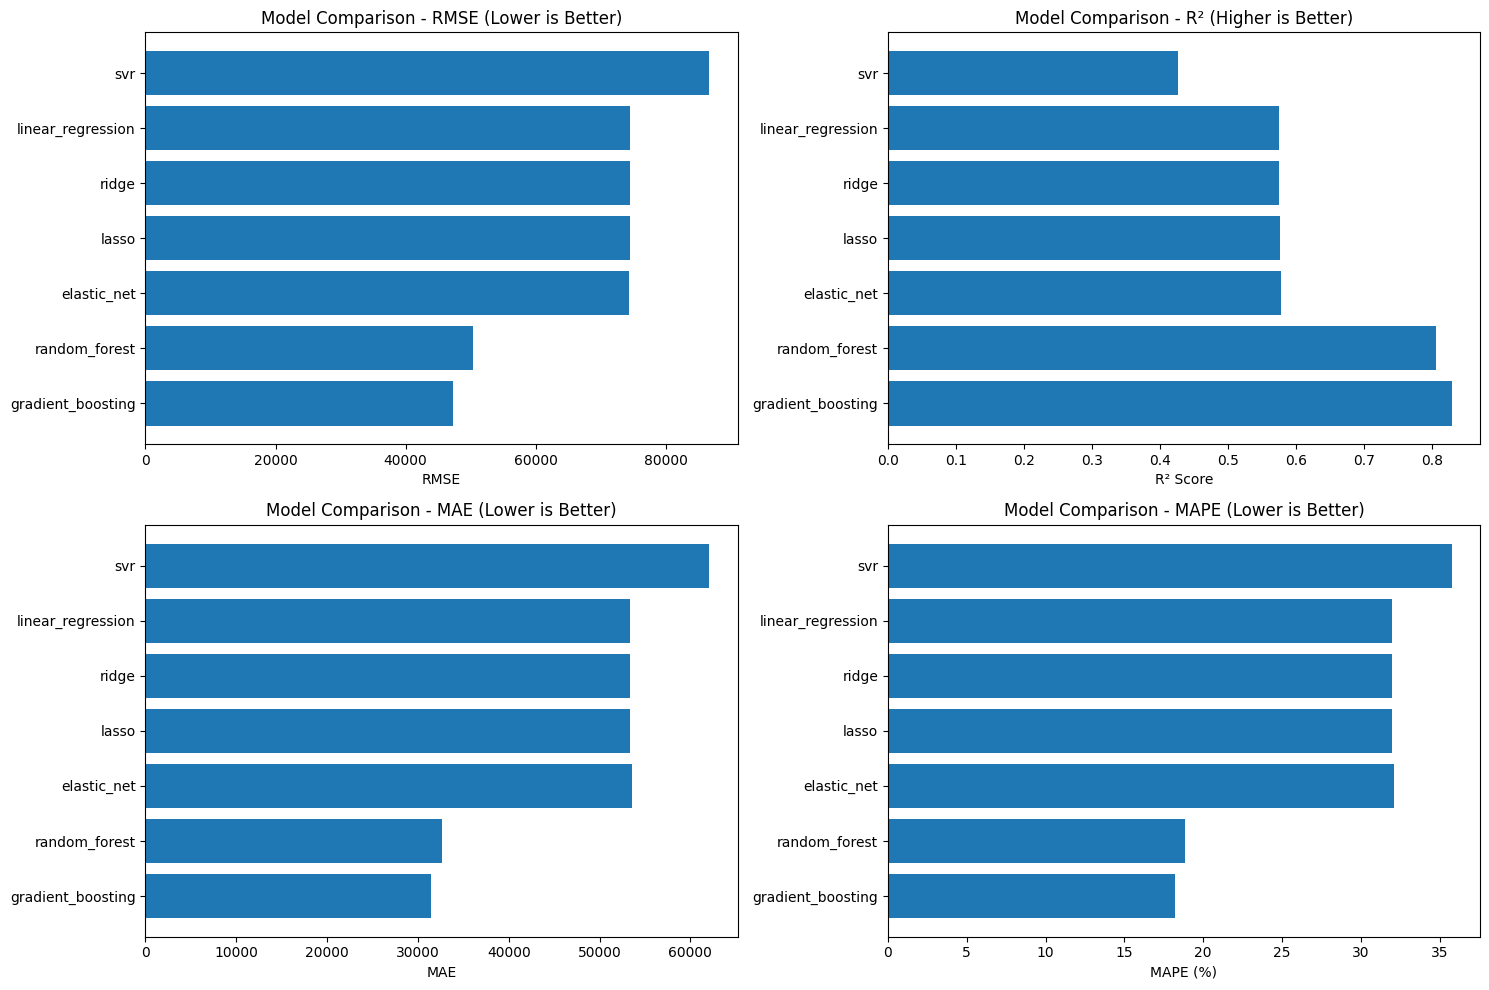


6. INTERPRETING BEST MODEL
Interpreting best model: gradient_boosting


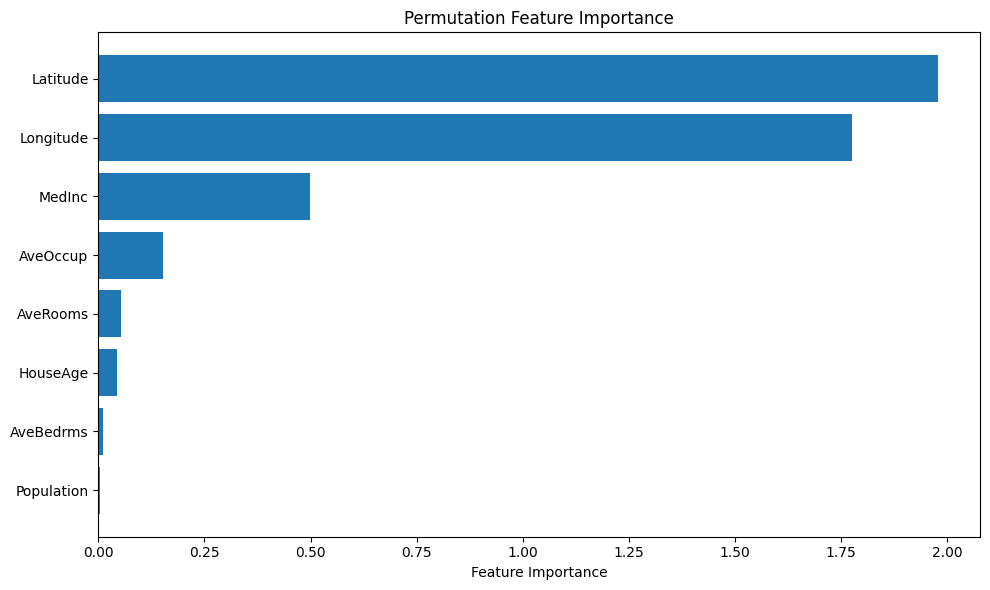


Feature Importance Ranking:
      feature  importance
6    Latitude    1.977964
7   Longitude    1.774794
0      MedInc    0.498307
5    AveOccup    0.152474
2    AveRooms    0.052699
1    HouseAge    0.044124
3   AveBedrms    0.011057
4  Population    0.004474

FINAL SUMMARY
Best Model: gradient_boosting
Best RMSE: $47,301.68
Best R² Score: 0.8293
Mean Absolute Error: $31,402.20
Mean Absolute Percentage Error: 18.24%

Sample Predictions (First 10 test samples):
   Actual Price  Predicted Price  Absolute Error  Percentage Error
0    $47,700.00       $47,510.36         189.64%             0.40%
1    $45,800.00       $96,274.98      $50,474.98           110.21%
2   $500,001.00      $488,512.37      $11,488.63             2.30%
3   $218,600.00      $242,187.74      $23,587.74            10.79%
4   $278,000.00      $237,411.59      $40,588.41            14.60%
5   $158,700.00      $171,797.30      $13,097.30             8.25%
6   $198,200.00      $237,999.34      $39,799.34            20.

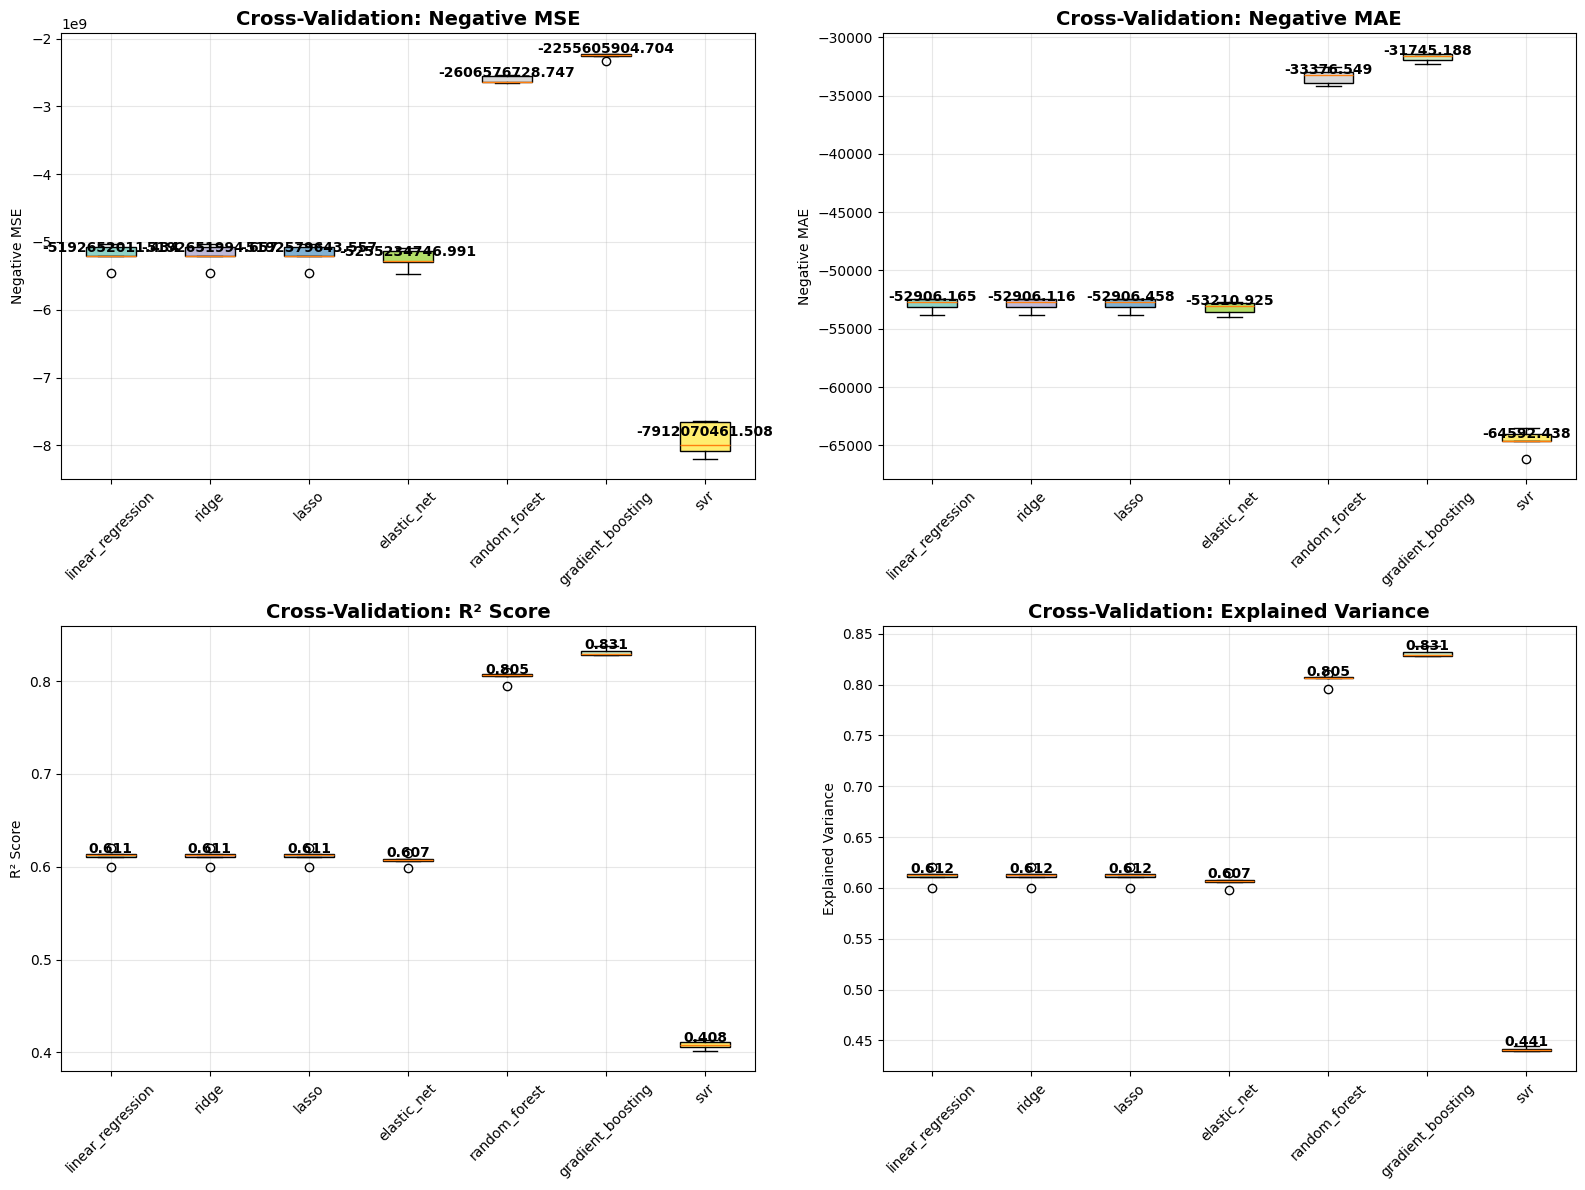


3. Generating Learning Curves...
Generating learning curve for linear_regression...
Generating learning curve for ridge...
Generating learning curve for lasso...


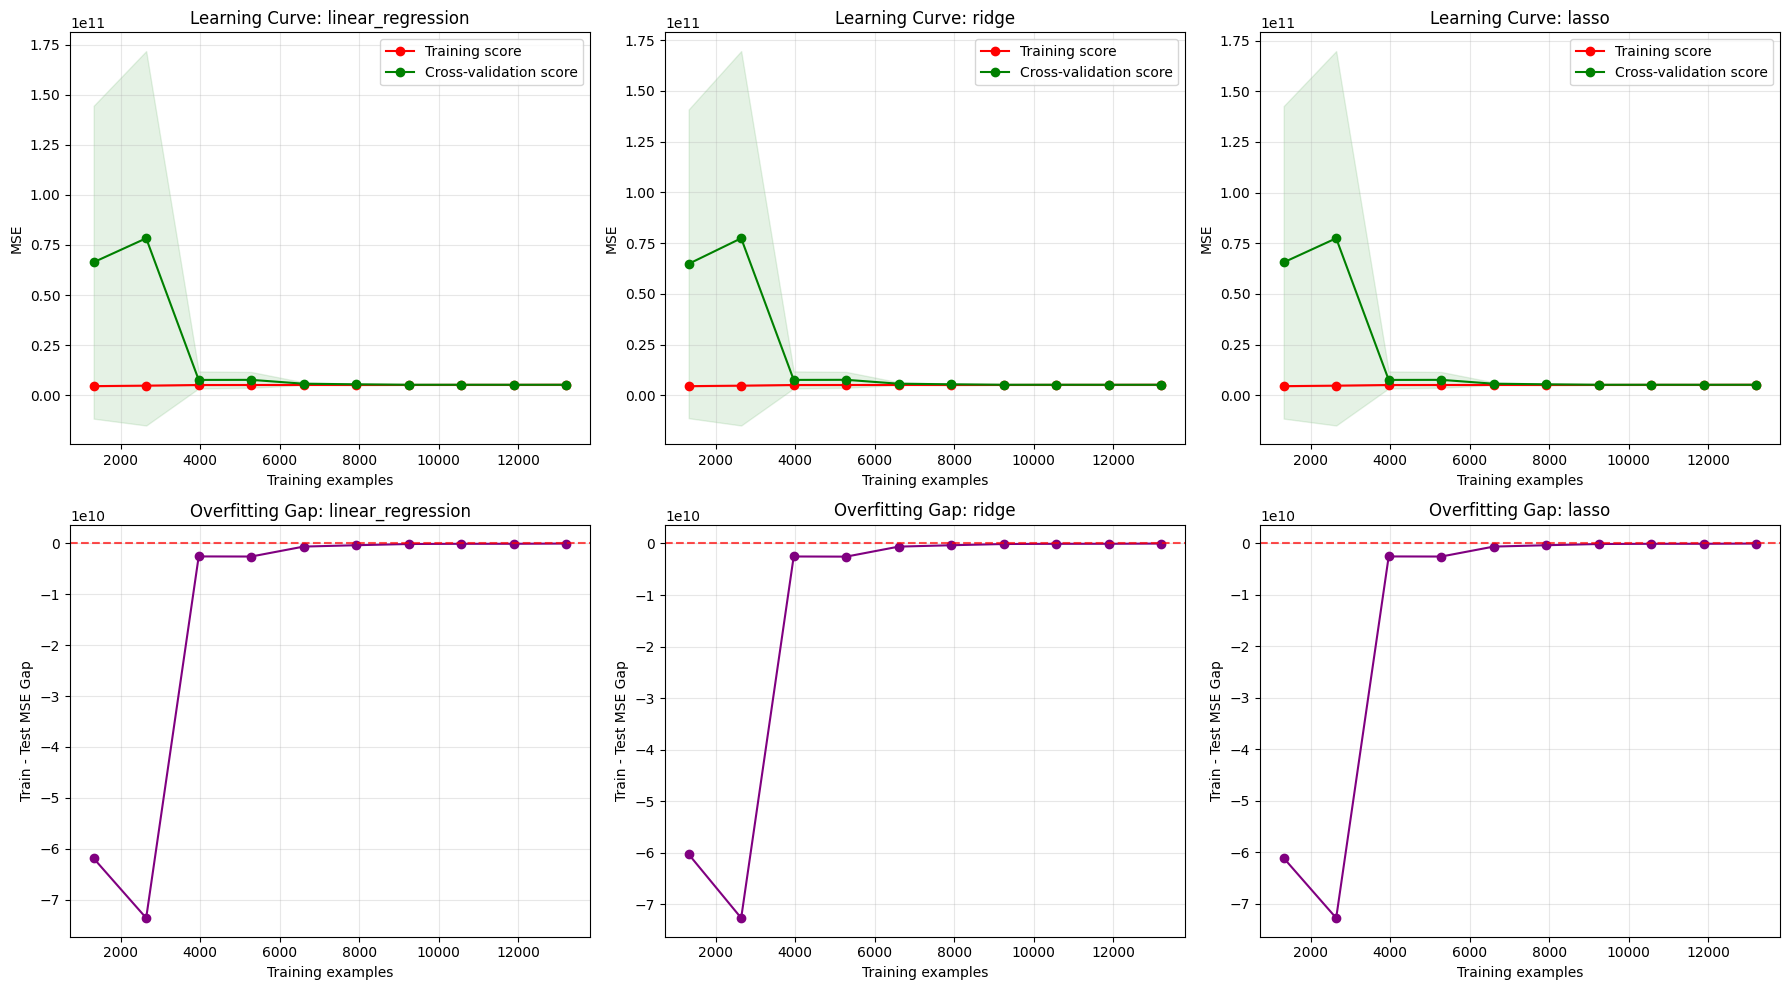


4. Generating Validation Curves...
Generating validation curve for Random Forest - n_estimators...
Generating validation curve for Gradient Boosting - n_estimators...


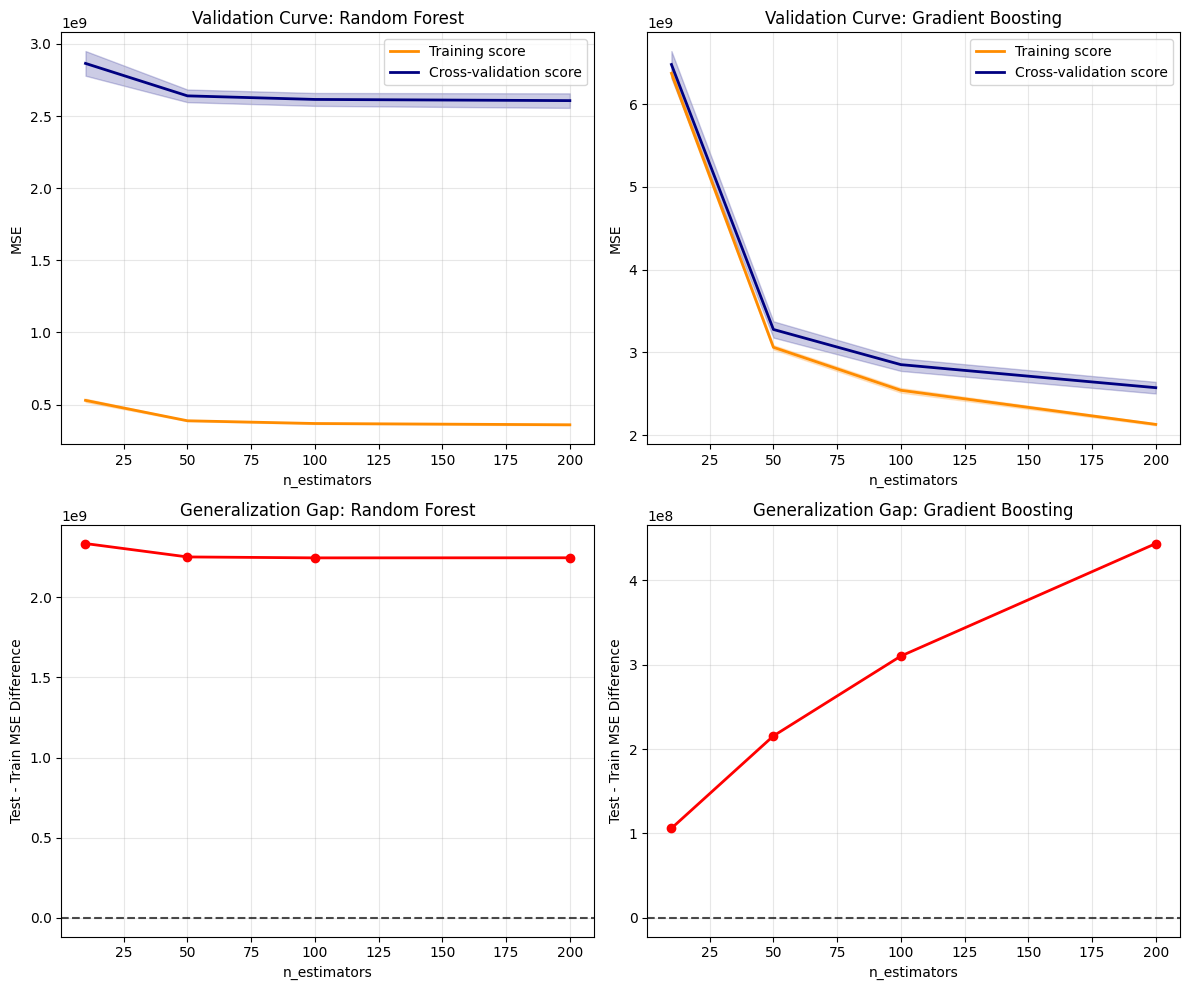


5. Analyzing Performance Across Folds...


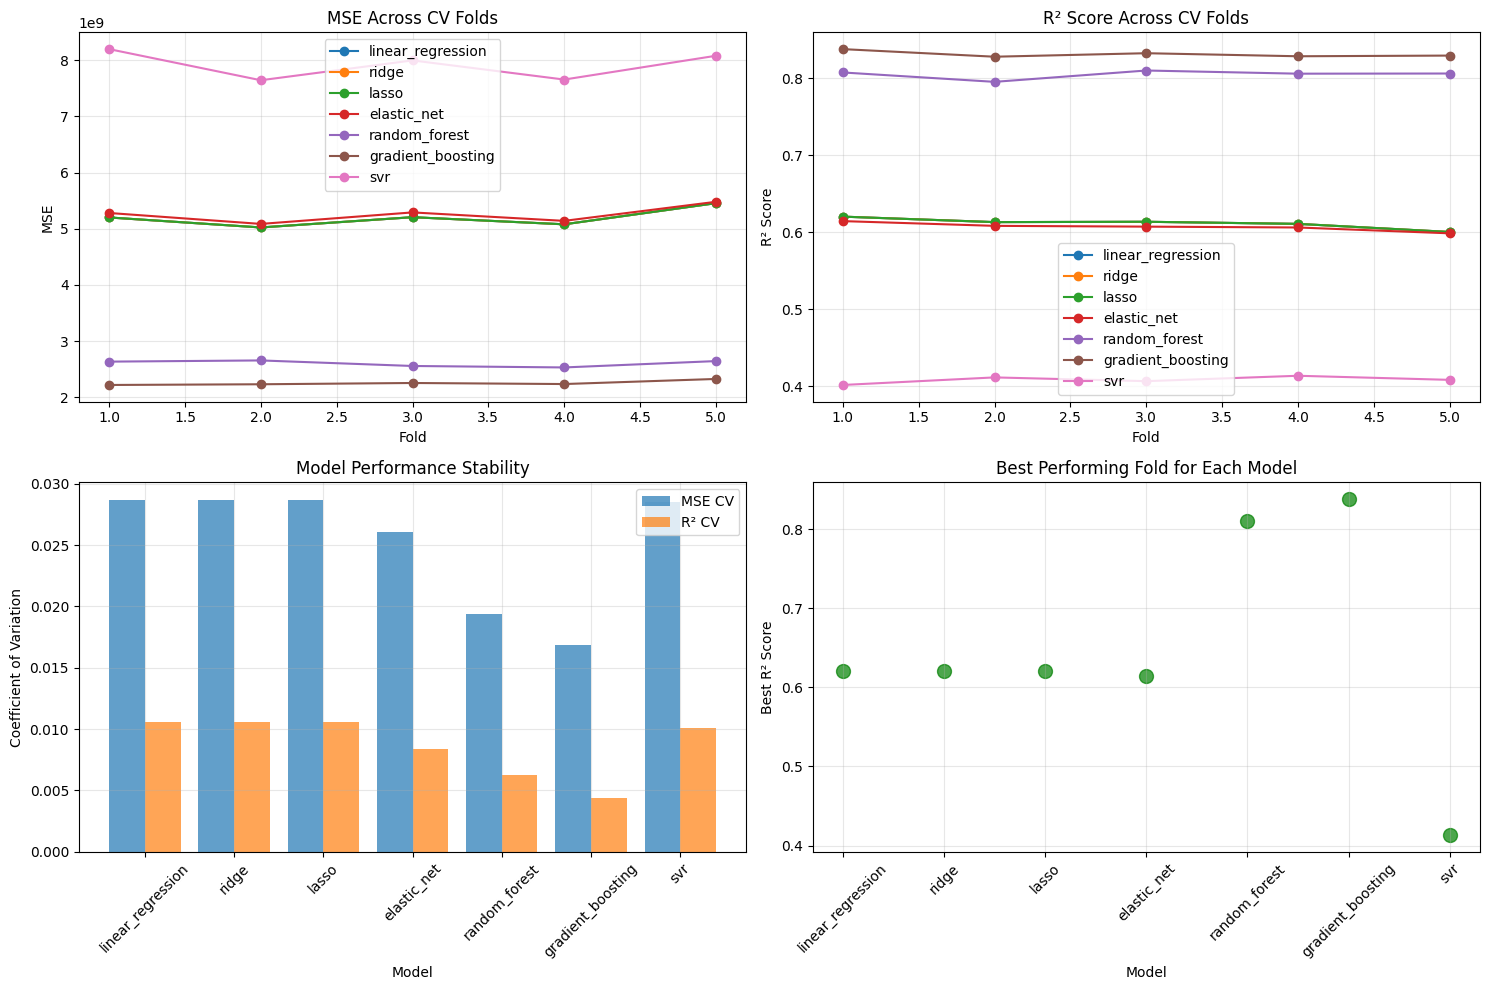


6. Generating Comprehensive Summary Table...

Cross-Validation Summary:
            Model        MSE Mean        MSE Std   MAE Mean  MAE Std R2 Mean R2 Std EXPLAINED_VARIANCE Mean EXPLAINED_VARIANCE Std   Train-Test Gap
linear_regression 5192652011.4337 148943854.1199 52906.1650 527.8909  0.6115 0.0065                  0.6115                 0.0065   -14691028.9383
            ridge 5192651994.6571 148937006.2007 52906.1158 527.8697  0.6115 0.0065                  0.6115                 0.0065   -14690997.6242
            lasso 5192579643.5572 148764393.8824 52906.4576 527.7047  0.6115 0.0064                  0.6115                 0.0065   -14613094.9112
      elastic_net 5255234746.9908 137080387.2096 53210.9254 478.3861  0.6068 0.0051                  0.6068                 0.0051   -14147582.2253
    random_forest 2606576728.7472  50448864.1035 33376.5487 608.2652  0.8049 0.0051                  0.8050                 0.0051 -2246765184.1234
gradient_boosting 2255605904.7043  3806


✅ Advanced CV Visualization Completed!


In [ ]:
# Add this to your main project execution
def enhanced_main():
    """Enhanced main function with advanced CV visualization"""

    # Your existing project setup
    project = HousingPricePrediction()

    # Run standard analysis
    project.run_complete_analysis()

    # Add advanced CV visualization
    print("\n" + "🎯" * 35)
    print("ADDING ADVANCED CROSS-VALIDATION VISUALIZATION")
    print("🎯" * 35)

    cv_visualizer = add_advanced_cv_to_project(project)

    print("\n✅ Advanced CV Visualization Completed!")
    return project, cv_visualizer

# Run the enhanced version
project, cv_visualizer = enhanced_main()